# Research Methods - Assignment 1

- André Santos
- Luís Espírito Santo
- Miguel Guerreiro

In [1]:
!pip -q install ipympl

In [97]:
#%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import math

from matplotlib.animation import FuncAnimation, PillowWriter 
from matplotlib import cm

from mpl_toolkits import mplot3d
from google.colab import output
output.enable_custom_widget_manager()

## Read Data

In [98]:
!gdown --id 14JNDxrBMdbWjGM4dbXUwnJY1zA9E2GSe

Downloading...
From: https://drive.google.com/uc?id=14JNDxrBMdbWjGM4dbXUwnJY1zA9E2GSe
To: /content/measurements_v2.csv
100% 4.52M/4.52M [00:00<00:00, 185MB/s]


In [99]:
df = pd.read_csv("measurements_v2.csv", index_col=0)
df = df[df.loc[:,"Exams"]<19]
df.describe()

,Exams,Percentage,Seed1,Seed2,Solution_code1,Time_code1,Solution_code2,Time_code2
count,101808.000000,101808.000000,101808.000000,101808.000000,50904.000000,50904.000000,50904.000000,50904.000000
mean,11.500000,0.500000,1327.500000,31237.500000,4.331919,5.917431,4.363665,5.994136
std,4.031149,0.291549,1.707834,1.707834,2.482257,39.394401,2.439653,39.624103
min,5.000000,0.000000,1325.000000,31235.000000,-1.000000,0.000004,-1.000000,0.000003
25%,8.000000,0.250000,1326.000000,31236.000000,3.000000,0.000023,3.000000,0.000008
50%,11.500000,0.500000,1327.500000,31237.500000,4.000000,0.000077,4.000000,0.000034
75%,15.000000,0.750000,1329.000000,31239.000000,6.000000,0.000656,6.000000,0.000670
max,18.000000,1.000000,1330.000000,31240.000000,13.000000,300.000004,13.000000,300.000013


In [100]:
#Defining extra columns
df["code"] = np.where(df["Time_code1"].isnull(), "Code2", "Code1" )
df["time"] = np.where(df["code"] == "Code1", df["Time_code1"], df["Time_code2"])
df["time_log"] = np.log(df["time"])
df["edges"] = df["Percentage"]*(df["Exams"]**2-df["Exams"])//2
df

,Exams,Percentage,Seed1,Seed2,Solution_code1,Time_code1,Solution_code2,Time_code2,code,time,time_log,edges
0,5,0.0,1325,31235,1.0,0.000009,NaN,NaN,Code1,0.000009,-11.618286,0.0
1,5,0.0,1325,31236,1.0,0.000009,NaN,NaN,Code1,0.000009,-11.618286,0.0
2,5,0.0,1325,31237,1.0,0.000008,NaN,NaN,Code1,0.000008,-11.736069,0.0
3,5,0.0,1325,31238,1.0,0.000008,NaN,NaN,Code1,0.000008,-11.736069,0.0
4,5,0.0,1325,31239,1.0,0.000020,NaN,NaN,Code1,0.000020,-10.819778,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
105219,18,1.0,1330,31236,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0
105220,18,1.0,1330,31237,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0
105221,18,1.0,1330,31238,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0
105222,18,1.0,1330,31239,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0


In [6]:
#d_temp = df.loc[df["code"]=="Code1", :].groupby(["Exams","edges"]).mean().reset_index()

#plt.scatter(d_temp["edges"], d_temp["time_log"])

## Exploratory Data Analysis

In [7]:
# Seed1 Values
df["Seed1"].unique()

array([1325, 1326, 1327, 1328, 1329, 1330])

In [8]:
# Seed2 Values
df["Seed2"].unique()

array([31235, 31236, 31237, 31238, 31239, 31240])

In [9]:
# Number of Exams (n)
df["Exams"].unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

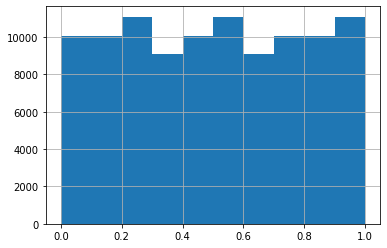

In [10]:
# Probabilities (p)
df["Percentage"].hist()

### Histograms

Text(367.48863636363626, 0.5, 'Log-Frequency')

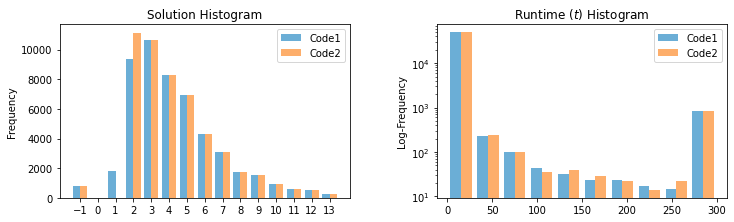

In [11]:
# Histograms of Time and Solutions
fig, axes = plt.subplots(nrows=1,
                         ncols=2,
                        figsize=(10, 3))

fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

columns = ["Solution_code1", "Solution_code2"]
colors = ["#6baed6","#fdae6b"]
legend = ["Code1", "Code2"]
title = 'Solution Histogram'
#axes[0].xticks = range(-1,14)
#axes[0].xticklabels = range(-1,14)
axes[0].hist(df.loc[:,columns].to_numpy(), color=colors, bins=(np.arange(-1,15)-0.5))
axes[0].legend(legend)
axes[0].set_title(title)
axes[0].set(xticks=range(-1,14))
axes[0].set_ylabel("Frequency")

columns = ["Time_code1", "Time_code2"]
colors = ["#6baed6","#fdae6b"]
legend = ["Code1", "Code2"]
title = 'Runtime ($t$) Histogram'
axes[1].hist(df.loc[:,columns].to_numpy(), color=colors, log=True)
axes[1].legend(legend)
axes[1].set_title(title)
axes[1].set_ylabel("Log-Frequency")

### Cutoff Count

Text(0.5, 1.0, 'Cutoff sample count - Code2')

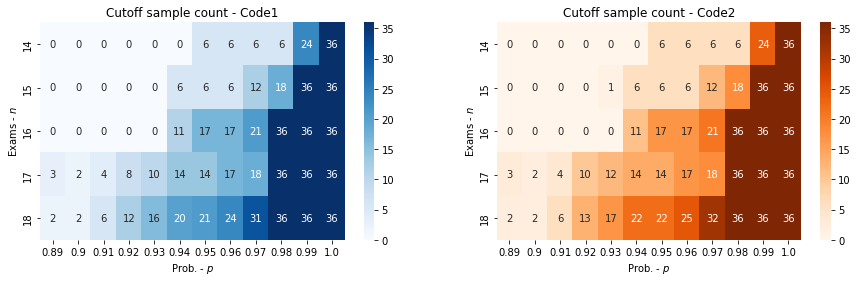

In [12]:
#Remove those with no solution
cutoff_index = ((df["Solution_code1"].isnull()) | (df["Solution_code1"]>0)) & (df["Solution_code2"].isnull()) | (df["Solution_code2"]>0)

df_remove = df.loc[~cutoff_index]
df_remove = df_remove.groupby(["Exams", "Percentage"]).count().reset_index()

# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4))

count = df_remove.pivot_table(values="Time_code1", index="Exams", columns='Percentage', aggfunc='first').fillna(0)
sns.heatmap(count,  cmap="Blues", annot=True, ax=axes[0], xticklabels=[f'{i:.2}' for i in sorted(df_remove["Percentage"].unique())])
axes[0].set_xlabel("Prob. - $p$")
axes[0].set_ylabel("Exams - $n$")
axes[0].set_title ("Cutoff sample count - Code1")

count = df_remove.pivot_table(values="Time_code2", index="Exams", columns='Percentage', aggfunc='first').fillna(0)
sns.heatmap(count,  cmap="Oranges", annot=True, ax=axes[1], xticklabels=[f'{i:.2}' for i in sorted(df_remove["Percentage"].unique())])
axes[1].set_xlabel("Prob. - $p$")
axes[1].set_ylabel("Exams - $n$")
axes[1].set_title ("Cutoff sample count - Code2")

### Correlation Matrix

([<matplotlib.axis.YTick at 0x7f60db107690>,
 [Text(0, 0.5, 'Seed 1'),
  Text(0, 1.5, 'Seed 2'),
  Text(0, 2.5, 'Exams - $n$'),
  Text(0, 3.5, 'Prob. - $p$'),
  Text(0, 4.5, 'Runtime \nCode 1 - $t_1$'),
  Text(0, 5.5, 'Runtime \nCode 2 - $t_2$')])

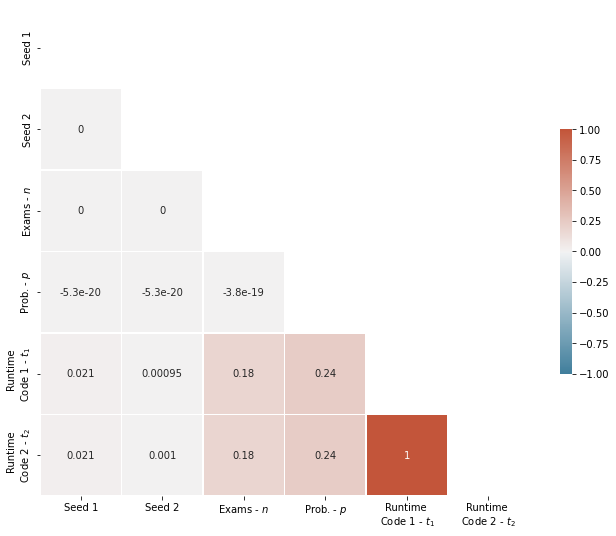

In [13]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set_theme(style="white")

# Generate a large random dataset
#rs = np.random.RandomState(33)
d = df.groupby(["Seed1","Seed2","Exams", "Percentage"]).mean().reset_index().loc[:,["Seed1", "Seed2", "Exams", "Percentage", "Time_code1", "Time_code2"]]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1, vmin=-1, annot=True, square=True, 
            linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ["Seed 1", "Seed 2", "Exams - $n$", "Prob. - $p$", "Runtime \nCode 1 - $t_1$", "Runtime \nCode 2 - $t_2$" ])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ["Seed 1", "Seed 2", "Exams - $n$", "Prob. - $p$", "Runtime \nCode 1 - $t_1$", "Runtime \nCode 2 - $t_2$" ])

### Q-Q Plot

Text(0.5, 1.0, 'QQ Plot - Log-Runtime')

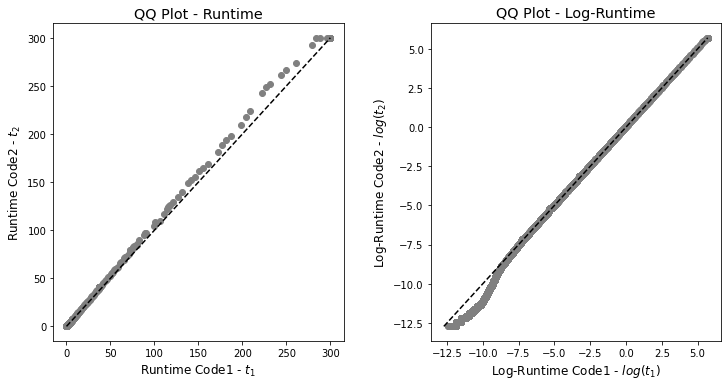

In [14]:
data_qq = df.groupby(["Seed1", "Seed2", "Exams", "Percentage"]).mean().reset_index()

fig, axes = plt.subplots(nrows=1,
                         ncols=2,
                         figsize=(10, 5))

fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

#1 Non log
percs = np.linspace(0,100,10001)

qn_a = np.percentile(data_qq["Time_code1"], percs)
qn_b = np.percentile(data_qq["Time_code2"], percs)

axes[0].plot(qn_a,qn_b, ls="", marker="o", color="grey")

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
axes[0].plot(x,x, color="k", ls="--")

axes[0].set_xlabel(f"Runtime Code1 - $t_1$", size='large')
axes[0].set_ylabel(f"Runtime Code2 - $t_2$", size='large')
axes[0].set_title("QQ Plot - Runtime", fontsize="x-large")  

#2 Log
percs = np.linspace(0,100,10001)

qn_a = np.percentile(np.log(data_qq["Time_code1"]), percs)
qn_b = np.percentile(np.log(data_qq["Time_code2"]), percs)

axes[1].plot(qn_a,qn_b, ls="", marker="o", color="grey")

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
axes[1].plot(x,x, color="k", ls="--")

axes[1].set_xlabel(f"Log-Runtime Code1 - $log(t_1)$", size='large')
axes[1].set_ylabel(f"Log-Runtime Code2 - $log(t_2)$", size='large')
axes[1].set_title("QQ Plot - Log-Runtime",  fontsize="x-large")  
#pplot(df, x="Time_code1", y="Time_code2", kind='qq',  
#      height=4, aspect=1.5, display_kws={"identity":True, "fit": True, "reg":True, "ci":0.00005})

### Boxplots

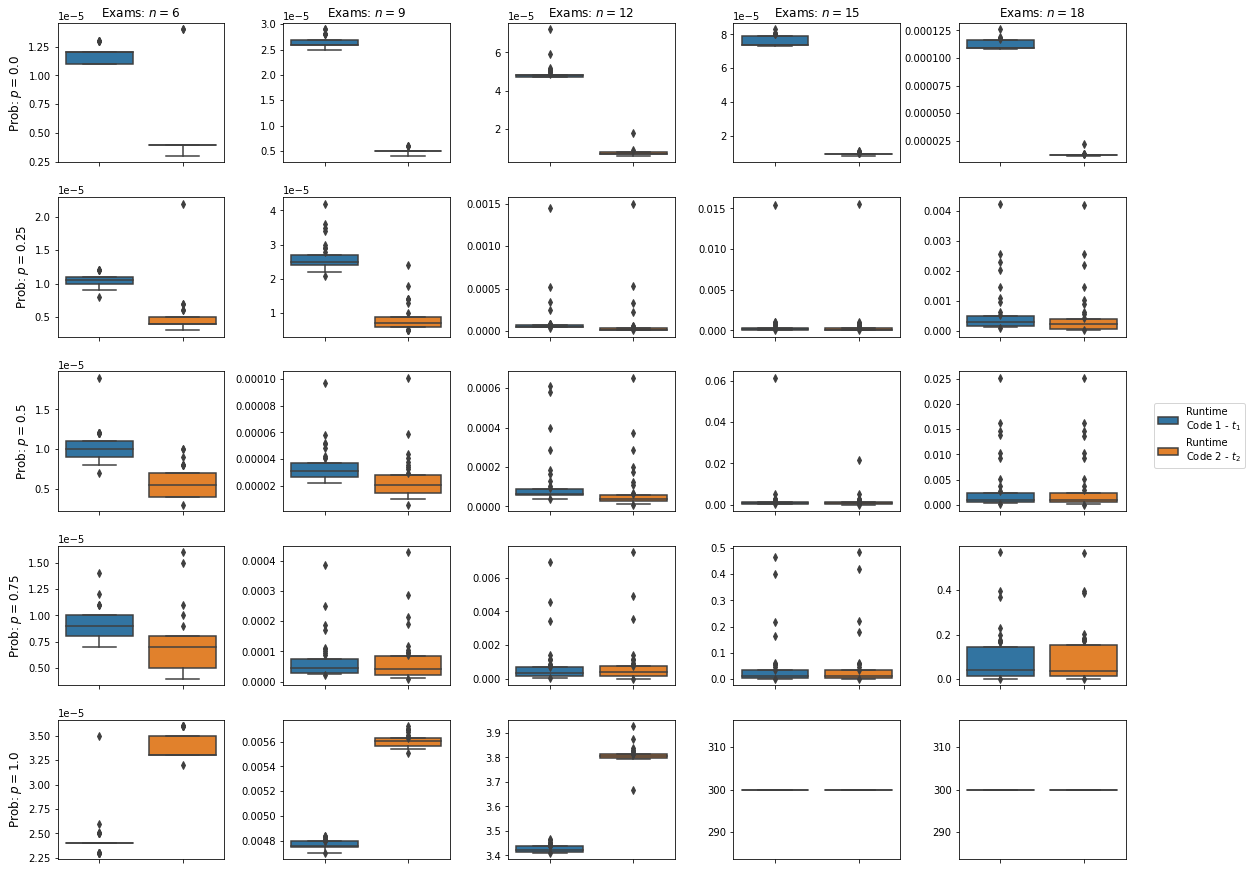

In [15]:
import itertools
import matplotlib

i=0

range_exams = range(6, 19, 3)
range_perc = np.linspace(0,1,5)
fig, axes = plt.subplots(nrows=len(range_perc),
                               ncols=len(range_exams),
                               figsize=(17, 15))
fig.tight_layout()
plt.subplots_adjust(top=0.8, 
                    right=0.9, wspace=0.35, hspace=0.25)

for (p,e),ax in zip(itertools.product(range_perc,range_exams),
                    list(itertools.chain.from_iterable(axes))):
  
    data = df.loc[(df["Exams"] == e) & (np.isclose(df["Percentage"],p))]
    m = sns.boxplot(x="code", y="time", data=data, ax=ax, whis=[0.05, 0.95])
    #m = sns.violinplot(x="code", y="time", data=data, ax=ax, whis=[0.05, 0.95])
    ax.set(ylabel=None)
    ax.set(xlabel=None)
    ax.set(xticklabels=[])
    #ax.set(yticklabels=[])
    handles = list(filter(lambda x: type(x) is matplotlib.patches.PathPatch, m.get_children()))
    #print(handles)

for ax, col in zip(axes[0], range_exams):
    ax.set_title(f"Exams: $n={col}$")

for ax, row in zip(axes[:,0], range_perc):
    ax.set_ylabel(f"Prob: $p={row}$", size='large')

#leg = ax.legend(loc='center', bbox_to_anchor=(0.5, -0.10), shadow=False, ncol=2)

labels = ["Runtime \nCode 1 - $t_1$", "Runtime \nCode 2 - $t_2$"]
fig.legend(handles, labels, loc='center right')


### 3D Scatter

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


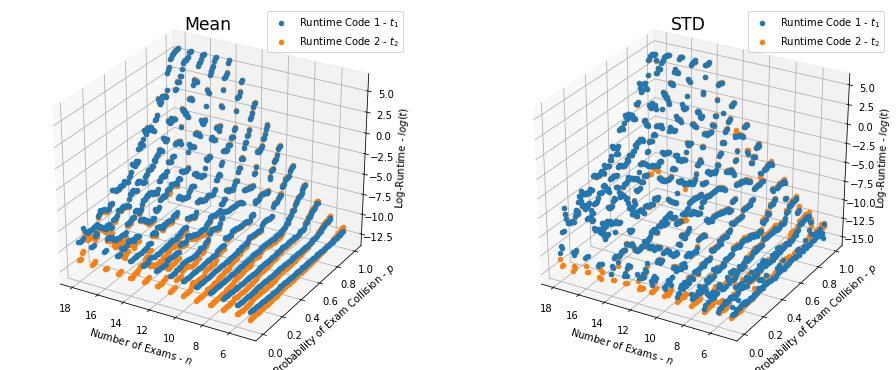

In [16]:
#Plot 3D scatter

pad = 1

def scatter3D(log):
  # Data for three-dimensional scattered points
  for code, color, desc in [(1, "Blues", "$t_1$"), (2, "Oranges", "$t_2$")]:
    if log:
      zdata = np.log(data_d["Time_code{}".format(code)])
    else:
      zdata = data_d["Time_code{}".format(code)]
    xdata = data_d["Exams"]
    ydata = data_d["Percentage"]
    s = ax.scatter3D(xdata, ydata, zdata, depthshade=False, cmap=color);
    s.set_label('Runtime Code {} - {}'.format(code, desc))

  #ticks = np.arange(0, 20, 2) - 14
  #tick_labels = [r'$10^{%i}$'%(i) for i in ticks]

  #ax.set_zticks(ticks)
  #ax.set_zticklabels(tick_labels)
  ax.set_xlabel('Number of Exams - $n$')
  ax.set_ylabel('Probability of Exam Collision - $p$')
  if log:
    ax.set_zlabel('Log-Runtime - $log(t)$')
  else:
    ax.set_zlabel('Runtime - $t$ [s]')
  ax.legend()

  #ax.view_init(30, 0)

fig = plt.figure(figsize=(14,5))
plt.subplots_adjust(right=1, top=1, bottom=0.01)

#mean
data_d = df.groupby(["Exams", "Percentage"]).mean().reset_index()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.invert_xaxis()
scatter3D(log=True)
ax.set_title("Mean", fontsize='xx-large')
#ax.annotate("Mean", xy=(-2, 2), xytext=(-ax.yaxis.labelpad - pad, 0),
#                xycoords=ax.yaxis.label, textcoords='offset points',
#                size='xx-large', ha='right', va='center', rotation="vertical")

#ax = fig.add_subplot(2, 2, 2, projection='3d')
#ax.invert_xaxis()
#scatter3D(log=True)

#std
data_d = df.groupby(["Exams", "Percentage"]).std().reset_index()
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.invert_xaxis()
scatter3D(log=True)
ax.set_title("STD", fontsize='xx-large')
#ax.annotate("STD", xy=(-2, 2), xytext=(-ax.yaxis.labelpad - pad, 0),
#                xycoords=ax.yaxis.label, textcoords='offset points',
#                size='xx-large', ha='right', va='center', rotation="vertical")


#ax = fig.add_subplot(2, 2, 4, projection='3d')
#ax.invert_xaxis()
#scatter3D(log=True)

plt.show()

#labels = ["Runtime \nCode 1 - $t_1$", "Runtime \nCode 2 - $t_2$"]
#fig.legend(handles, labels, loc='center right')

In [17]:

# SHOWS A 3D WIDGET
#widgets.interact(scatter3D, t= widgets.Play(min=0,max =15));

In [18]:
#CREATE A GIF

"""
def update(i):  
     ax.view_init(30, i)

ani = FuncAnimation(fig, update, np.arange(0, 360,20), init_func=scatter3D)  
writer = PillowWriter(fps=2)  
ani.save("3d.gif", writer=writer)
"""  

'\ndef update(i):  \n     ax.view_init(30, i)\n\nani = FuncAnimation(fig, update, np.arange(0, 360,20), init_func=scatter3D)  \nwriter = PillowWriter(fps=2)  \nani.save("3d.gif", writer=writer)\n'

### Variation

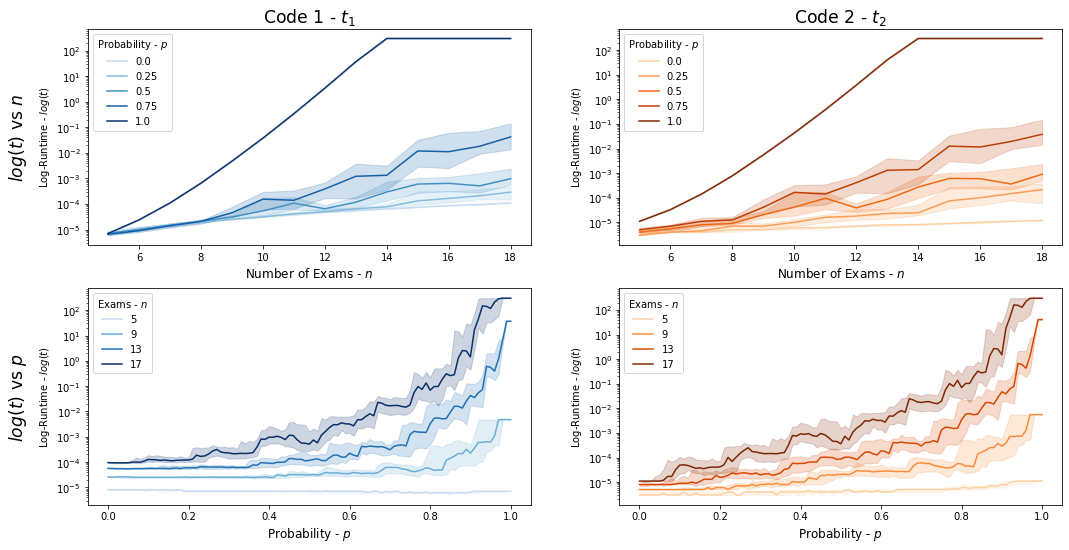

In [19]:
from matplotlib import cm

fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(14, 7))
fig.tight_layout()
plt.subplots_adjust(right=1, top=1, wspace=0.2, hspace=0.2)

limit = 0.75

#p in selected
p_l = np.linspace(0,1,5)
p_index = df.loc[:, ["Percentage"]].applymap(lambda x: any(np.isclose(x,p_l)))["Percentage"]
p_mean_d = df.loc[p_index].groupby(["Exams", "Percentage"]).quantile(0.5).reset_index()
p_ql_d = df.loc[p_index].groupby(["Exams", "Percentage"]).quantile(limit).reset_index()
p_qu_d = df.loc[p_index].groupby(["Exams", "Percentage"]).quantile(1-limit).reset_index()

#n in selected
n_l = np.linspace(5,17,4)
n_index = df.loc[:, ["Exams"]].applymap(lambda x: any(np.isclose(x,n_l)))["Exams"]
n_mean_d = df.loc[n_index].groupby(["Exams", "Percentage"]).quantile(0.5).reset_index()
n_ql_d = df.loc[n_index].groupby(["Exams", "Percentage"]).quantile(limit).reset_index()
n_qu_d = df.loc[n_index].groupby(["Exams", "Percentage"]).quantile(1-limit).reset_index()


for i, code, color in [(0, "Code1", "Blues"), 
                       (1, "Code2", "Oranges"), ]: 
  ax = axes[0][i]
  #line_1 = sns.lineplot(data=df.loc[p_index], x="Exams", 
  #                      y=f"Time_{code.lower()}", 
  #                      hue="Percentage", 
  #                      palette=color, ax=ax,
  #                      estimator=min)

  cmap = cm.get_cmap(color)

  for p, shade in zip(p_l, np.linspace(0.25,1,len(p_l))):

    filtered_mean_d = p_mean_d.loc[np.isclose(p_mean_d["Percentage"],p)]
    filtered_ql_d = p_ql_d.loc[np.isclose(p_ql_d["Percentage"],p)]
    filtered_qu_d = p_qu_d.loc[np.isclose(p_qu_d["Percentage"],p)]

    line, = ax.plot(filtered_mean_d["Exams"], 
                    filtered_mean_d[f"Time_{code.lower()}"], 
                    '-',
                    color=cmap(shade))
    ax.fill_between(filtered_mean_d["Exams"], 
                    filtered_ql_d[f"Time_{code.lower()}"], 
                    filtered_qu_d[f"Time_{code.lower()}"], 
                    color=cmap(shade),
                    alpha=0.2)
    line.set_label(f"{p:.2}")

  ax.set(yscale="log")
  ax.set_xlabel("Number of Exams - $n$", size='large')
  ax.set_ylabel('Log-Runtime - $log(t)$')
  ax.set_title("Code {} - $t_{}$".format(code[-1], code[-1]), fontsize='xx-large')
  ax.legend(title="Probability - $p$")

  ax = axes[1][i]
  for n, shade in zip(n_l, np.linspace(0.25,1,len(n_l))):
    filtered_mean_d = n_mean_d.loc[np.isclose(n_mean_d["Exams"],n)]
    filtered_ql_d = n_ql_d.loc[np.isclose(n_ql_d["Exams"],n)]
    filtered_qu_d = n_qu_d.loc[np.isclose(n_qu_d["Exams"],n)]

    line, = ax.plot(filtered_mean_d["Percentage"], 
                    filtered_mean_d[f"Time_{code.lower()}"], 
                    '-',
                    color=cmap(shade))
    ax.fill_between(filtered_mean_d["Percentage"], 
                    filtered_ql_d[f"Time_{code.lower()}"], 
                    filtered_qu_d[f"Time_{code.lower()}"],
                    color=cmap(shade),
                    alpha=0.2)
    
    line.set_label(f"{int(n):d}")
  ax.set(yscale="log")
  ax.set_xlabel("Probability - $p$", size='large')
  ax.set_ylabel('Log-Runtime - $log(t)$')
  #ax.set_title("Code {} - $t_{}$".format(code[-1], code[-1]), fontsize='xx-large')
  ax.legend(title="Exams - $n$")

pad = 5
for ax, row in zip(axes[:,0], ["$log(t)$ vs $n$", "$log(t)$ vs $p$"]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='xx-large', ha='right', va='center', rotation="vertical")

## Linear Regression

### Multiple-Curve Graph (vs. Exams)

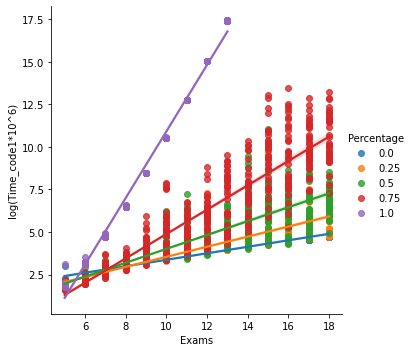

In [20]:
p_class = df.loc[:, ["Percentage"]].applymap(lambda x: str(round(x, 2)))
p_index = p_class.applymap(lambda x: x in ["0.0", "0.25", "0.5", "0.75", "1.0"])["Percentage"]

df1 = df.copy()
df1 = df1.loc[df['Solution_code1'] > -1]
df1['Time_code1'] = df1["Time_code1"].apply(lambda y: math.log(y * (10 ** 6)))
grid = sns.lmplot(data=df1.loc[p_index], x="Exams", y="Time_code1", hue="Percentage")
grid = grid.set_axis_labels("Exams", "log(Time_code1*10^6)")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


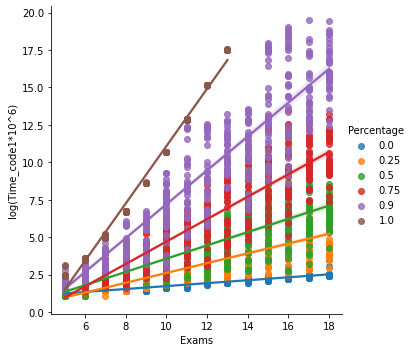

In [21]:
p_class = df.loc[:, ["Percentage"]].applymap(lambda x: str(round(x, 2)))
p_index = p_class.applymap(lambda x: x in ["0.0", "0.25", "0.5", "0.75", "0.9", "1.0"])["Percentage"]

df2 = df.copy()
df2 = df2.loc[df['Solution_code2'] > -1]
df2['Time_code2'] = df2["Time_code2"].apply(lambda y: math.log(y * (10 ** 6)))
grid = sns.lmplot(data=df2.loc[p_index], x="Exams", y="Time_code2", hue="Percentage")
grid = grid.set_axis_labels("Exams", "log(Time_code1*10^6)")

### Single-Curve Graph (vs. Exams)

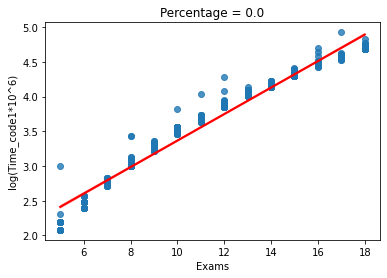

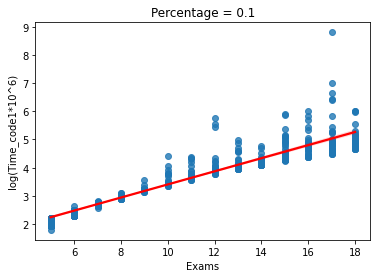

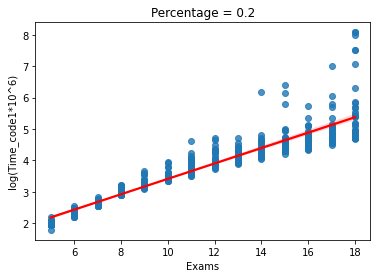

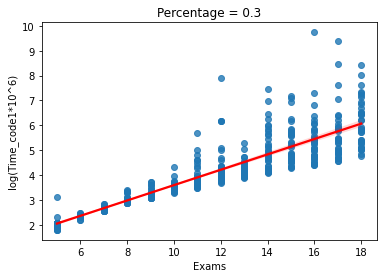

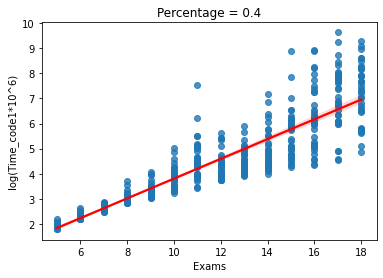

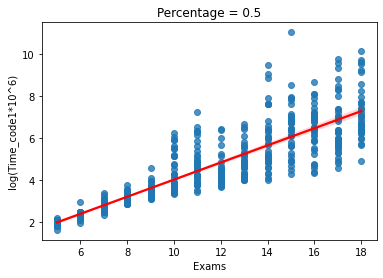

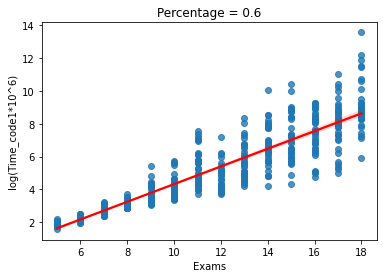

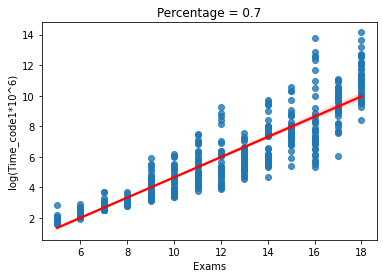

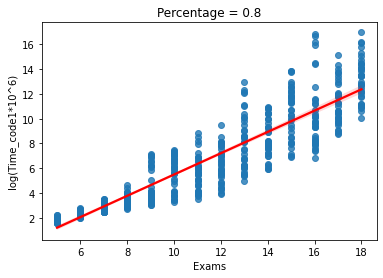

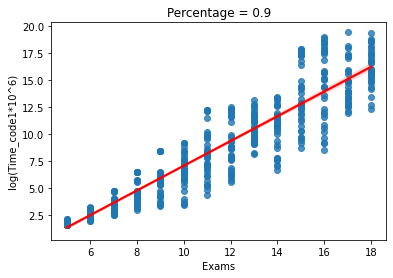

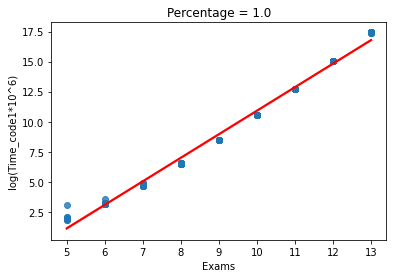

In [22]:
for p in range(0, 11, 1):

    p = p/10
    p_index = p_class.applymap(lambda x: x in [str(p)])["Percentage"]

    grid = sns.regplot(data=df1.loc[p_index], x="Exams", y="Time_code1", line_kws={"color": "red"})
    grid.set(ylabel="log(Time_code1*10^6)", title=f"Percentage = {str(p)}")

    plt.show()

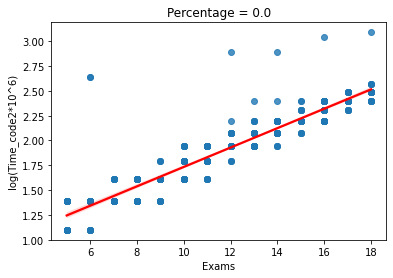

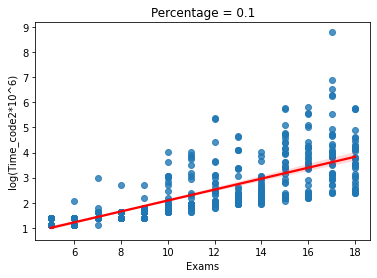

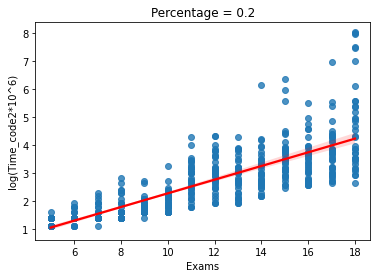

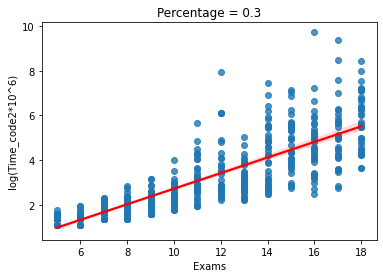

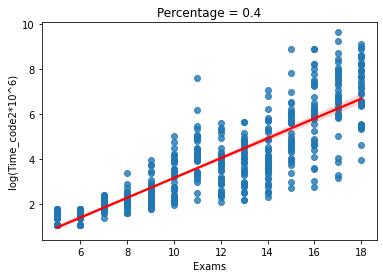

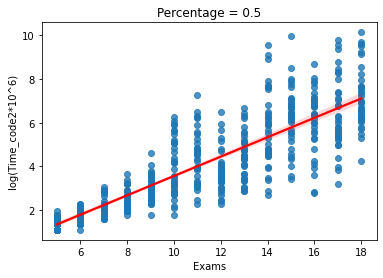

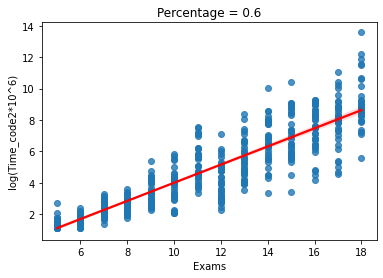

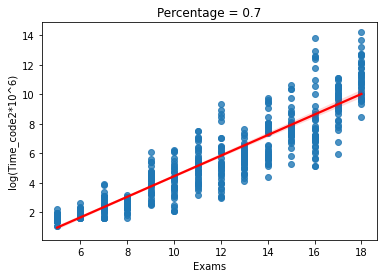

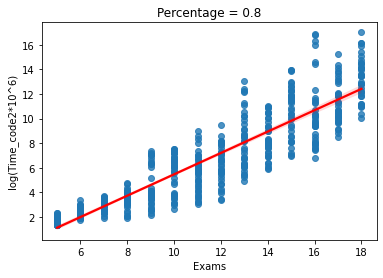

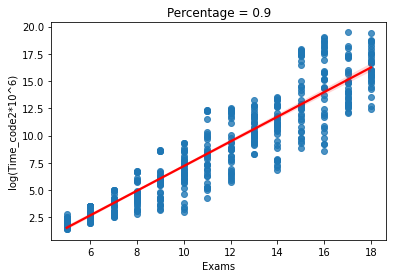

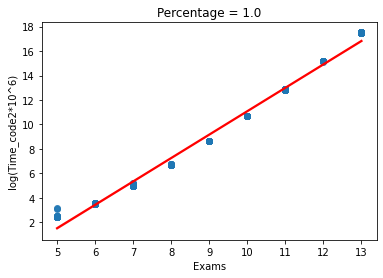

In [23]:
for p in range(0, 11, 1):

    p = p/10
    p_index = p_class.applymap(lambda x: x in [str(p)])["Percentage"]

    grid = sns.regplot(data=df2.loc[p_index], x="Exams", y="Time_code2", line_kws={"color": "red"})
    grid.set(ylabel="log(Time_code2*10^6)", title=f"Percentage = {str(p)}")

    plt.show()

### Multiple-Curve Graph (vs. Prob)

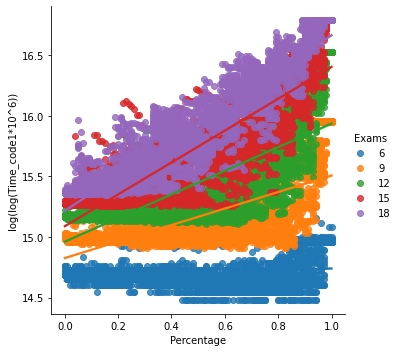

In [24]:
p_class = df.loc[:, ["Exams"]].applymap(lambda x: str(x))
p_index = p_class.applymap(lambda x: x in ["6", "9", "12", "15", "18"])["Exams"]

df_x = df.copy()

df_x['Time_code1'] = df_x["Time_code1"].apply(lambda y: math.log(y * (10 ** 6)))
df_x['Time_code1'] = df_x["Time_code1"].apply(lambda y: math.log(y * (10 ** 6)))
grid = sns.lmplot(data=df_x.loc[p_index], x="Percentage", y="Time_code1", hue="Exams")
grid = grid.set_axis_labels("Percentage", "log(log(Time_code1*10^6))")

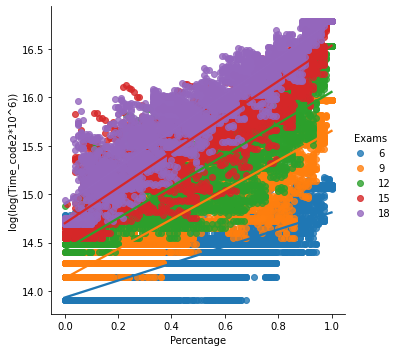

In [25]:
p_class = df.loc[:, ["Exams"]].applymap(lambda x: str(x))
p_index = p_class.applymap(lambda x: x in ["6", "9", "12", "15", "18"])["Exams"]

df_x = df.copy()

df_x['Time_code2'] = df_x["Time_code2"].apply(lambda y: math.log(y * (10 ** 6)))
df_x['Time_code2'] = df_x["Time_code2"].apply(lambda y: math.log(y * (10 ** 6)))
grid = sns.lmplot(data=df_x.loc[p_index], x="Percentage", y="Time_code2", hue="Exams")
grid = grid.set_axis_labels("Percentage", "log(log(Time_code2*10^6))")

### Single-Curve Graph (vs. Prob)

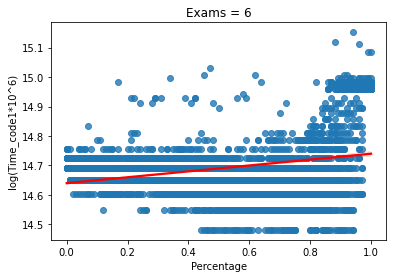

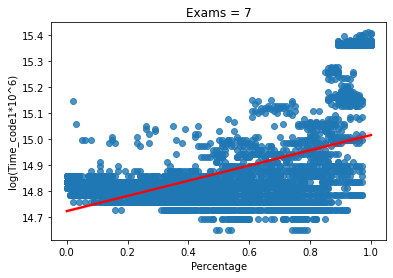

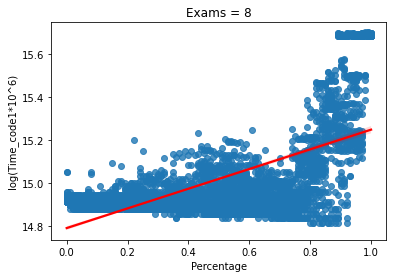

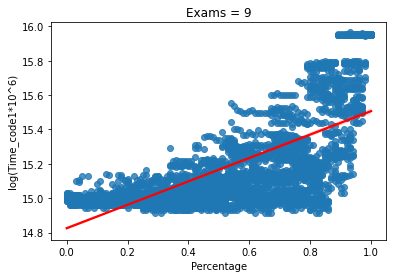

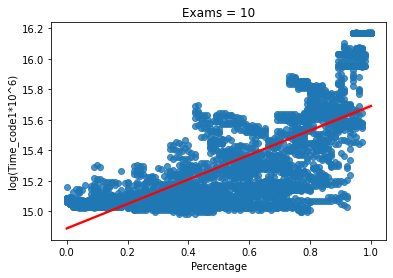

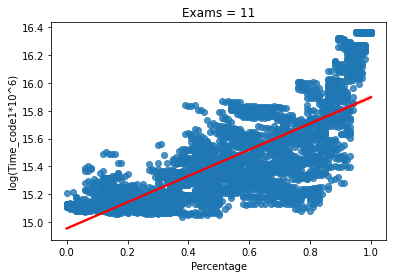

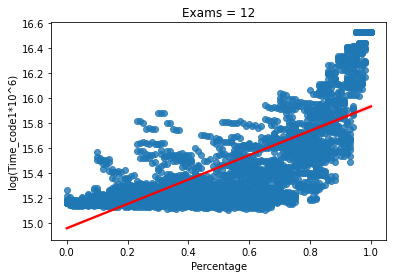

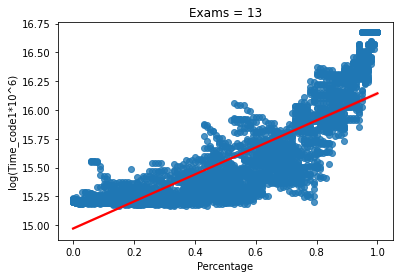

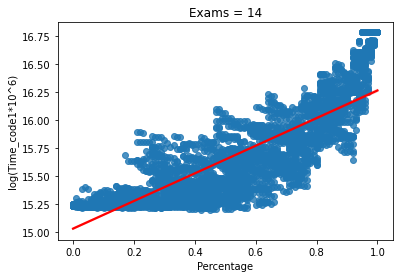

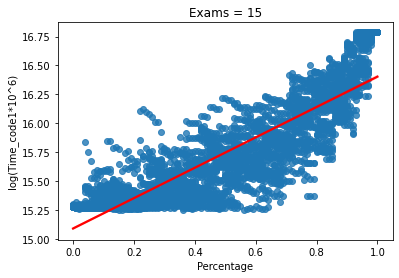

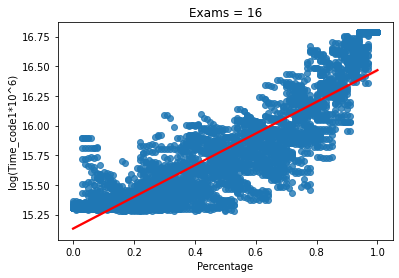

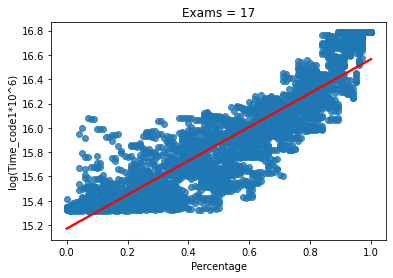

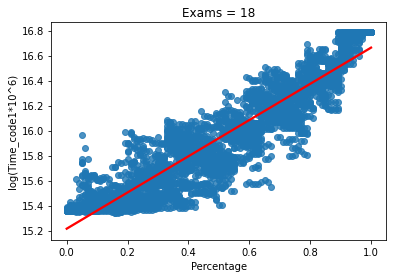

In [26]:
p_class = df.loc[:, ["Exams"]].applymap(lambda x: str(x))
time_code = "Time_code1"
df_x = df.copy()
df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))
df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))
for e in range(6, 19, 1):

    p_index = p_class.applymap(lambda x: x in [str(e)])["Exams"]

    grid = sns.regplot(data=df_x.loc[p_index], x="Percentage", y=time_code, line_kws={"color": "red"})
    grid.set(ylabel=f"log({time_code}*10^6)", title=f"Exams = {str(e)}")

    plt.show()

### Single-curve Graph with colors and labels


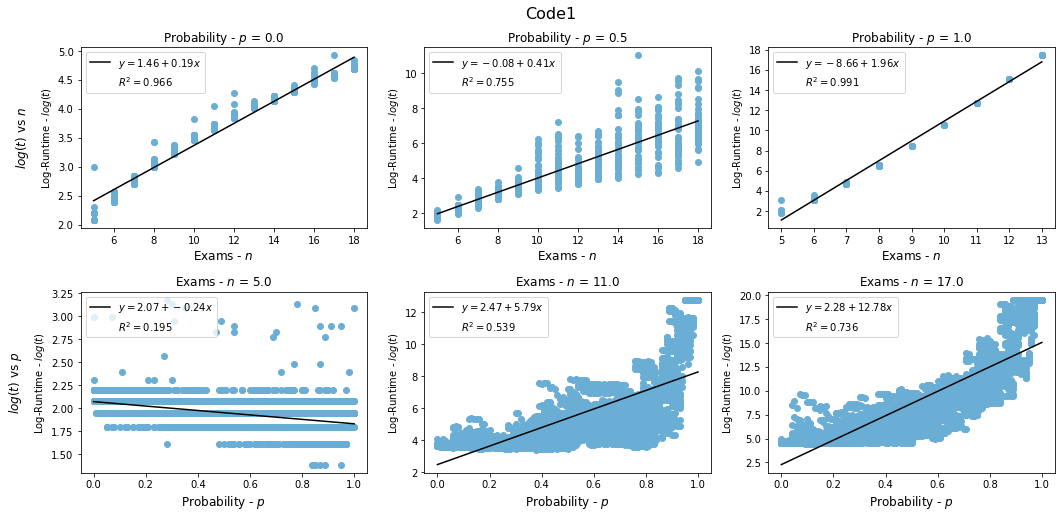

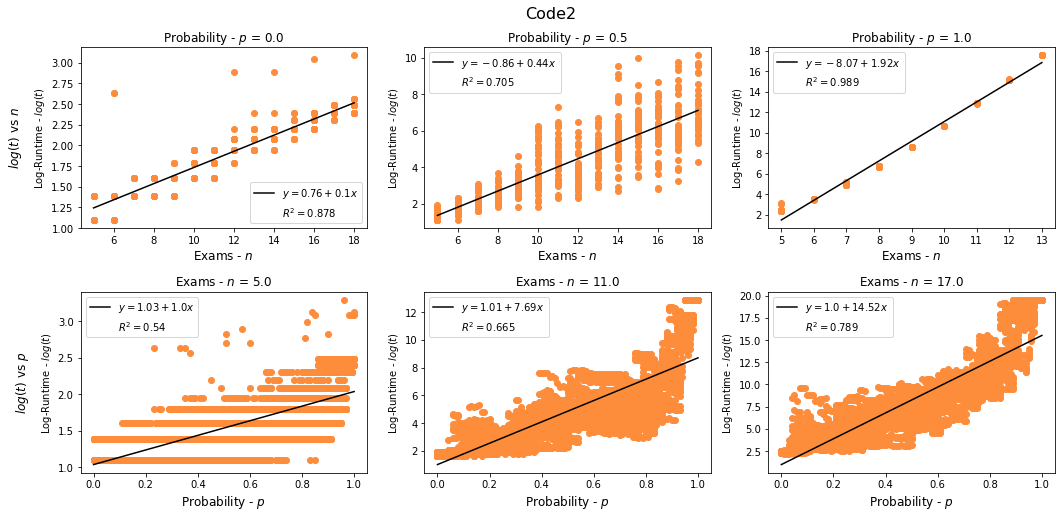

In [27]:
from sklearn.linear_model import LinearRegression
from matplotlib import cm


#p in selected
p_l = np.linspace(0,1,3)


#n in selected
n_l = np.linspace(5,17,3)

for code, color in [("Code1", "Blues"), 
                    ("Code2", "Oranges"), ]: 
  fig, axes = plt.subplots(nrows=2,
                         ncols=len(p_l),
                         figsize=(14, 7))
  fig.tight_layout()
  plt.subplots_adjust(right=1, top=0.9, wspace=0.2, hspace=0.35)

  cmap = cm.get_cmap(color)
  color = cmap(0.5)

  for i, (e,p) in enumerate(zip(n_l,p_l)):

    ax = axes[0][i]

    f_index = np.isclose(df["Percentage"],p)
    filtered_df = df.loc[f_index,["Exams", f"Time_{code.lower()}"]].dropna()
    filtered_df = filtered_df.loc[df[f'Solution_{code.lower()}'] > -1]
    X = filtered_df["Exams"].to_numpy().reshape(-1, 1)
    y = filtered_df[f"Time_{code.lower()}"].apply(lambda y: math.log(y * (10 ** 6))).to_numpy()
    reg = LinearRegression().fit(X, y)

    ax.scatter(x=X, 
               y=y,
               color=color)
    linspace = np.linspace(np.min(X), np.max(X), 1000).reshape(-1, 1)
    pred = reg.predict(linspace)
    l_line, = ax.plot(linspace, 
                      pred, 
                      color="k")
    l_ghost, = ax.plot([],
                       [],
                       color="w")

    #ax.set(yscale="log")
    ax.set_xlabel("Exams - $n$", size='large')
    ax.set_ylabel('Log-Runtime - $log(t)$')
    ax.set_title("Probability - $p$ = {}".format(p), fontsize='large')
    ax.legend([f"$y = {np.round(reg.intercept_,2)} + {np.round(reg.coef_[0],2)}x$",
               f"$R^2 = {np.round(reg.score(X, y),3)}$"])
    #ax.legend(handles[-1:]*2, ["4","2","3"])
    
    #set ticks
    #min_y = min(np.min(y), np.min(pred))
    #max_y = max(np.max(y), np.max(pred))  
    #ticks = np.ceil(np.linspace(min_y, max_y, 5))
    #ax.set_yticks(ticks)
    #ax.set_yticklabels(list(map(lambda x: '$10^{}{}{}$'.format("{",x,"}"), ticks)))

    ax = axes[1][i]

    f_index = np.isclose(df["Exams"],e)
    filtered_df = df.loc[f_index,["Percentage", f"Time_{code.lower()}"]].dropna()
    X = filtered_df["Percentage"].to_numpy().reshape(-1, 1)
    y = filtered_df[f"Time_{code.lower()}"].apply(lambda y: math.log(y * (10 ** 6))).to_numpy()
    reg = LinearRegression().fit(X, y)

    ax.scatter(x=X, 
               y=y,
               color=color)
    linspace = np.linspace(np.min(X), np.max(X), 1000).reshape(-1, 1)
    pred = reg.predict(linspace)
    l_line, = ax.plot(linspace, 
                      pred, 
                      color="k")
    l_ghost, = ax.plot([],
                       [],
                       color="w")

    ax.set_xlabel("Probability - $p$", size='large')
    ax.set_ylabel('Log-Runtime - $log(t)$')
    ax.set_title("Exams - $n$ = {}".format(e), fontsize='large')
    ax.legend([f"$y = {np.round(reg.intercept_,2)} + {np.round(reg.coef_[0],2)}x$",
               f"$R^2 = {np.round(reg.score(X, y),3)}$"])

  fig.suptitle(f"{code}", fontsize=16)
  pad = 5
  for ax, row in zip(axes[:,0], ["$log(t)$ vs $n$", "$log(t)$ vs $p$"]):
      ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                  xycoords=ax.yaxis.label, textcoords='offset points',
                  size='large', ha='right', va='center', rotation="vertical")
      
  plt.show()


### $R^2$ study

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

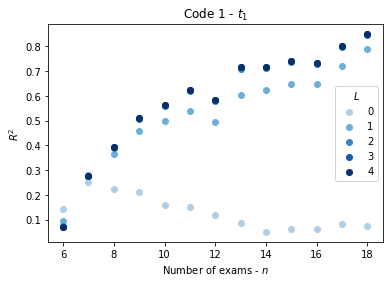

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

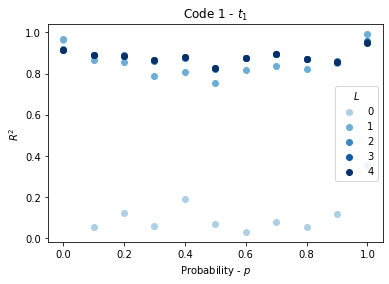

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

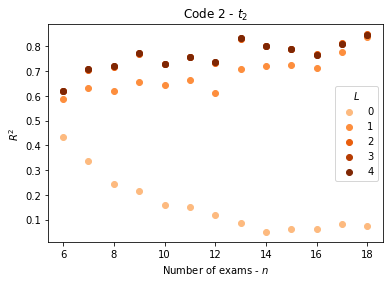

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

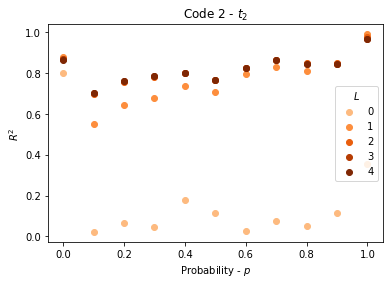

In [28]:
from sklearn.linear_model import LinearRegression


m_variable = "Exams"
x_variable = "Percentage"

# code_x = 1

# n_logs = 2

for code_x, code, color in [(1, "Code1", "Blues"),
                       (2, "Code2", "Oranges"), ]:
    time_code = "Time_code" + str(code_x)
    solution_code = "Solution_code" + str(code_x)
    cmap = cm.get_cmap(color)

    for _ in range(2):
        p_class = df.loc[:, [m_variable]].applymap(lambda x: str(round(x, 2)))

        df_x = df.copy()
        df_x = df_x.loc[df[solution_code] > -1]
        #df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))
        #df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))

        n_logs = np.arange(5)
        for n_log, shade in zip(n_logs, np.linspace(0.33,1,len(n_logs))):

        # if n_logs > 0:
        #     df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))
        # if n_logs > 1:
        #     df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))
            exams = range(6, 19, 1)
            percentages = np.linspace(0, 1, 11)
            # percentages = percentages / 10
            r2 = []
            if m_variable == "Exams":
                m_array = exams
            else:
                m_array = percentages

            for m in m_array:

                p_index = np.isclose(df_x[m_variable],m)

                X = df_x.loc[p_index][x_variable].to_numpy().reshape(-1, 1)
                # even = slice(None, None, 2)
                # X = X[even]
                # y = 1 * x_0 + 2 * x_1 + 3
                y = df_x.loc[p_index][time_code].dropna().to_numpy()
                reg = LinearRegression().fit(X, y)
                # print(reg.score(X, y))
                #print(reg.coef_)
                #print(reg.intercept_)
                r2.append(reg.score(X, y))


                # grid = sns.regplot(data=df_x.loc[p_index], x=x_variable, y=time_code, line_kws={"color": "red"})
                # grid.set(ylabel=f"log({time_code}*10^6)", title=f"{m_variable} = {str(m)}")

                # plt.show()

            plt.scatter(x=m_array, y=r2, c=cmap(shade))

            df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))

        plt.legend(n_logs, title="$L$", loc='center right')
        plt.title(f"Code {code_x} - $t_{code_x}$")
        if m_variable == "Percentage":
            xlabel = "Probability - $p$"
        else:
            xlabel = "Number of exams - $n$"
        plt.xlabel(xlabel)
        plt.ylabel("$R^2$")
        plt.show()

        m_variable, x_variable = x_variable, m_variable

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


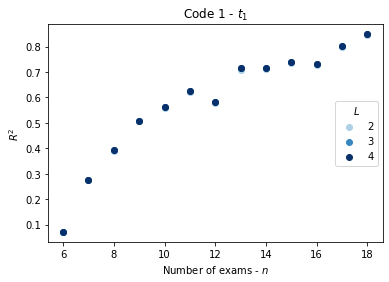

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


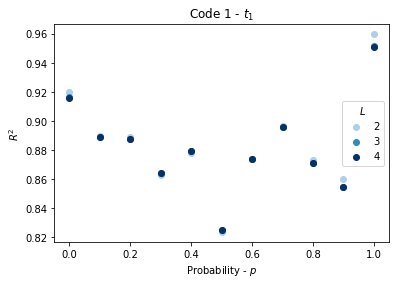

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


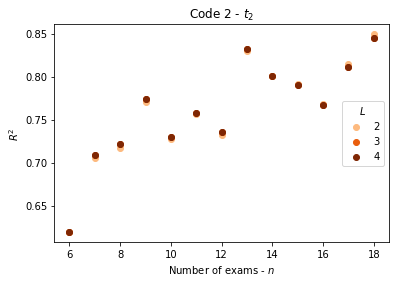

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


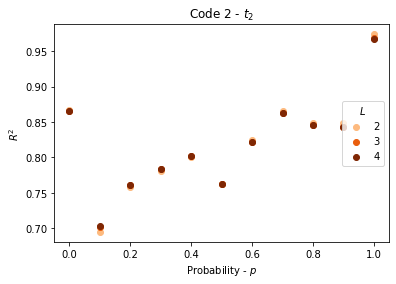

In [29]:
from sklearn.linear_model import LinearRegression


m_variable = "Exams"
x_variable = "Percentage"

# code_x = 1

# n_logs = 2

for code_x, code, color in [(1, "Code1", "Blues"),
                       (2, "Code2", "Oranges"), ]:
    time_code = "Time_code" + str(code_x)
    solution_code = "Solution_code" + str(code_x)
    cmap = cm.get_cmap(color)

    for _ in range(2):
        p_class = df.loc[:, [m_variable]].applymap(lambda x: str(round(x, 2)))

        df_x = df.copy()
        df_x = df_x.loc[df[solution_code] > -1]
        df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))
        df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))

        n_logs = np.arange(2, 5)
        for n_log, shade in zip(n_logs, np.linspace(0.33,1,len(n_logs))):

        # if n_logs > 0:
        #     df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))
        # if n_logs > 1:
        #     df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))
            exams = range(6, 19, 1)
            percentages = np.linspace(0, 1, 11)
            # percentages = percentages / 10
            r2 = []
            if m_variable == "Exams":
                m_array = exams
            else:
                m_array = percentages

            for m in m_array:
                m = round(m, 2)

                p_index = p_class.applymap(lambda x: x in [str(m)])[m_variable]

                X = df_x.loc[p_index][x_variable].to_numpy().reshape(-1, 1)
                # even = slice(None, None, 2)
                # X = X[even]
                # y = 1 * x_0 + 2 * x_1 + 3
                y = df_x.loc[p_index][time_code].dropna().to_numpy()
                reg = LinearRegression().fit(X, y)
                # print(reg.score(X, y))
                #print(reg.coef_)
                #print(reg.intercept_)
                r2.append(reg.score(X, y))


                # grid = sns.regplot(data=df_x.loc[p_index], x=x_variable, y=time_code, line_kws={"color": "red"})
                # grid.set(ylabel=f"log({time_code}*10^6)", title=f"{m_variable} = {str(m)}")

                # plt.show()

            plt.scatter(x=m_array, y=r2, c=cmap(shade))

            df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))

        plt.legend(n_logs, title="$L$", loc='center right')
        plt.title(f"Code {code_x} - $t_{code_x}$")
        if m_variable == "Percentage":
            xlabel = "Probability - $p$"
        else:
            xlabel = "Number of exams - $n$"
        plt.xlabel(xlabel)
        plt.ylabel("$R^2$")
        plt.show()

        m_variable, x_variable = x_variable, m_variable

Log: 0
Log: 1
Log: 2
Log: 3


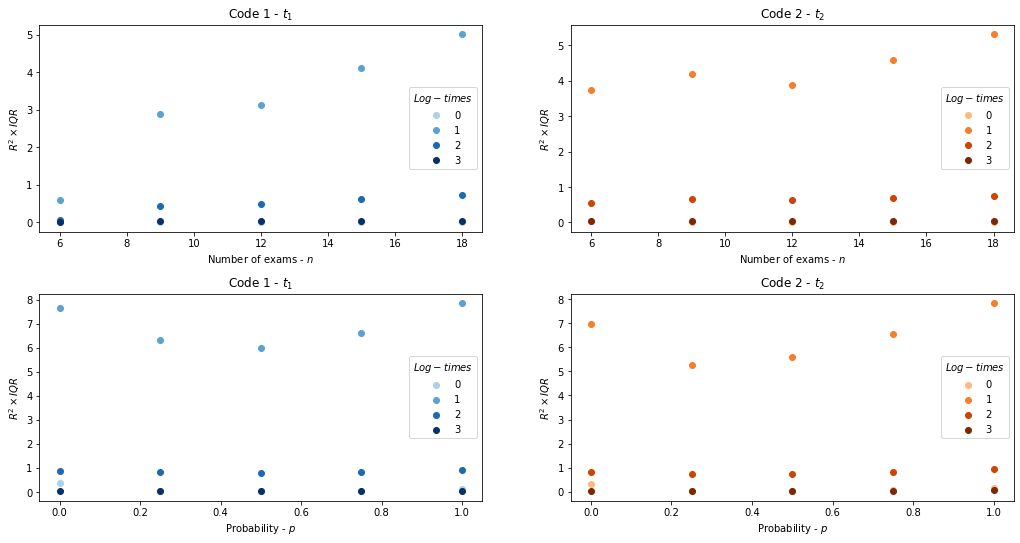

In [30]:
# Graph showing that increasing the number of logs actually improves R^2 but
# hides variability making interquartile range (IQR) really small and pushing 
# all data into a constant-like function (more like a log function but that moves
# closer and closer to 0)

from sklearn.linear_model import LinearRegression

fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(14, 7))
fig.tight_layout()
plt.subplots_adjust(right=1, top=1, wspace=0.2, hspace=0.3)

exams = range(6, 19, 3)
percentages = np.linspace(0, 1, 5)
df_x = df.copy()
n_logs = np.arange(4)

for n_log, shade in zip(n_logs,np.linspace(0.33,1,len(n_logs))):
  print("Log:", n_log)

  for row, (m_variable, x_variable) in enumerate([("Exams", "Percentage"),
                                                  ("Percentage", "Exams")]):

    if m_variable == "Exams":
      m_array = exams
    else:
      m_array = percentages

    r2={1:[],2:[]}
    for m in m_array:
      p_index = df.loc[:, [m_variable]].applymap(lambda x: np.isclose(x,m))[m_variable]

      for code_x in range(1,3):
        time_code = "Time_code" + str(code_x)
        solution_code = "Solution_code" + str(code_x)
        f_index = df[solution_code] > -1

        X = df_x.loc[p_index & f_index][x_variable].to_numpy().reshape(-1, 1)
        y = df_x.loc[p_index & f_index][time_code].dropna().to_numpy()

        q3, q1 = np.percentile(y, [75 ,25])
        iqr = q3 - q1

        reg = LinearRegression().fit(X, y)

        r2[code_x].append(reg.score(X, y))
        #print(reg.score(X, y))
        #print(reg.coef_)
        #print(reg.intercept_)


    for col, code_x, code, color in [(0, 1, "Code1", "Blues"),
                                     (1, 2, "Code2", "Oranges")]:
      cmap = cm.get_cmap(color)

      axes[row][col].scatter(x=m_array, y=np.array(r2[code_x])*iqr, color=cmap(shade))
      axes[row][col].legend(n_logs, title="$Log-times$", loc='center right')
      axes[row][col].set_title(f"Code {code_x} - $t_{code_x}$")
      if m_variable == "Percentage":
          xlabel = "Probability - $p$"
      else:
          xlabel = "Number of exams - $n$"
      axes[row][col].set_xlabel(xlabel)
      axes[row][col].set_ylabel(r"$R^2 \times IQR$")

  for code_x in range(1,3):
    time_code = "Time_code" + str(code_x)
    df_x[time_code] = df_x[time_code].apply(lambda y: math.log(y * (10 ** 6)))

## Graph Representation

In [31]:
#Get graphs
!pip -q install --upgrade gdown
!pip -q install parse
!gdown -q --folder https://drive.google.com/drive/folders/1ZETO3mYCEz7MWHcusXVeEJpjW1TyU9r9?usp=sharing

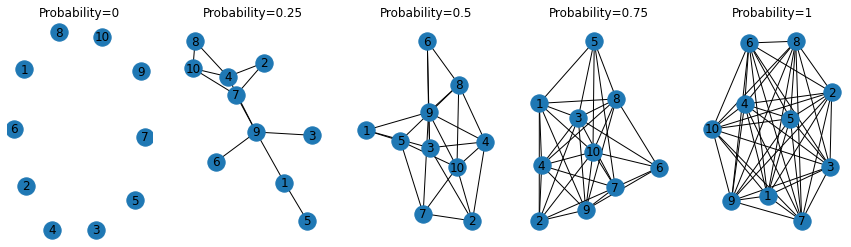

In [32]:
import networkx as nx
from parse import parse

fig, axes = plt.subplots(nrows=1,
                               ncols=5,
                               figsize=(15, 4))

for j,p in enumerate([0, 0.25, 0.5, 0.75, 1]):
  g = nx.Graph()
  with open(f"graphs/data{j+1}.in","r") as f1:
    lines = f1.readlines()
  nodes, edges = parse("{} {}\n", lines[0])

  for i in range(int(nodes)):
    g.add_node(i+1)

  for l in lines[1:]:
    n1, n2 = parse("{} {}\n", l)
    g.add_edge(int(n1), int(n2))

  nx.draw(g, with_labels=True, ax=axes[j])
  axes[j].set_title(f"Probability={p}")

## One-line EAD

### SweetViz

In [36]:
!pip install -q sweetviz

     |████████████████████████████████| 15.1 MB 185 kB/s 


In [101]:
p_table = df.pivot_table(values="time", index=["Exams", "Percentage", "Seed1", "Seed2"], columns='code', aggfunc='first')

In [102]:
p_table_a = p_table.loc[[tuple(row) for index, row in df.loc[:,["Exams", "Percentage", "Seed1", "Seed2"]].iterrows()]].reset_index()

In [109]:
df.loc[:, "time_difference"] = (p_table_a['Code1'] - p_table_a['Code2'])

In [110]:
df

,Exams,Percentage,Seed1,Seed2,Solution_code1,Time_code1,Solution_code2,Time_code2,code,time,time_log,edges,time_difference
0,5,0.0,1325,31235,1.0,0.000009,NaN,NaN,Code1,0.000009,-11.618286,0.0,0.000005
1,5,0.0,1325,31236,1.0,0.000009,NaN,NaN,Code1,0.000009,-11.618286,0.0,0.000005
2,5,0.0,1325,31237,1.0,0.000008,NaN,NaN,Code1,0.000008,-11.736069,0.0,0.000004
3,5,0.0,1325,31238,1.0,0.000008,NaN,NaN,Code1,0.000008,-11.736069,0.0,0.000005
4,5,0.0,1325,31239,1.0,0.000020,NaN,NaN,Code1,0.000020,-10.819778,0.0,0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105219,18,1.0,1330,31236,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0,NaN
105220,18,1.0,1330,31237,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0,NaN
105221,18,1.0,1330,31238,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0,NaN
105222,18,1.0,1330,31239,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0,NaN


In [104]:
df

,Exams,Percentage,Seed1,Seed2,Solution_code1,Time_code1,Solution_code2,Time_code2,code,time,time_log,edges,time_difference
0,5,0.0,1325,31235,1.0,0.000009,NaN,NaN,Code1,0.000009,-11.618286,0.0,0.000005
1,5,0.0,1325,31236,1.0,0.000009,NaN,NaN,Code1,0.000009,-11.618286,0.0,0.000005
2,5,0.0,1325,31237,1.0,0.000008,NaN,NaN,Code1,0.000008,-11.736069,0.0,0.000004
3,5,0.0,1325,31238,1.0,0.000008,NaN,NaN,Code1,0.000008,-11.736069,0.0,0.000005
4,5,0.0,1325,31239,1.0,0.000020,NaN,NaN,Code1,0.000020,-10.819778,0.0,0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105219,18,1.0,1330,31236,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0,NaN
105220,18,1.0,1330,31237,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0,NaN
105221,18,1.0,1330,31238,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0,NaN
105222,18,1.0,1330,31239,NaN,NaN,-1.0,300.000001,Code2,300.000001,5.703782,153.0,NaN


In [105]:
import sweetviz as sv

my_report = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)


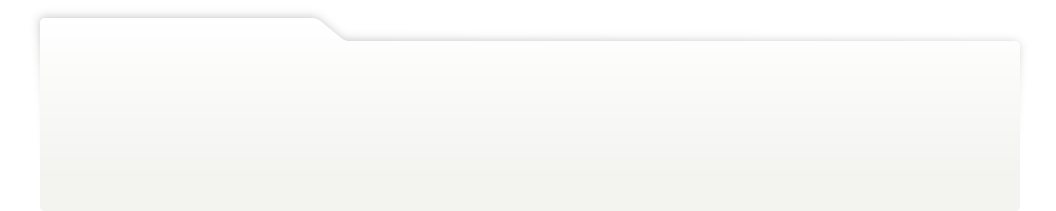
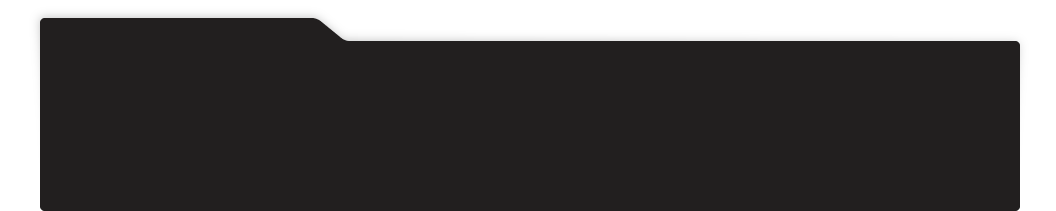
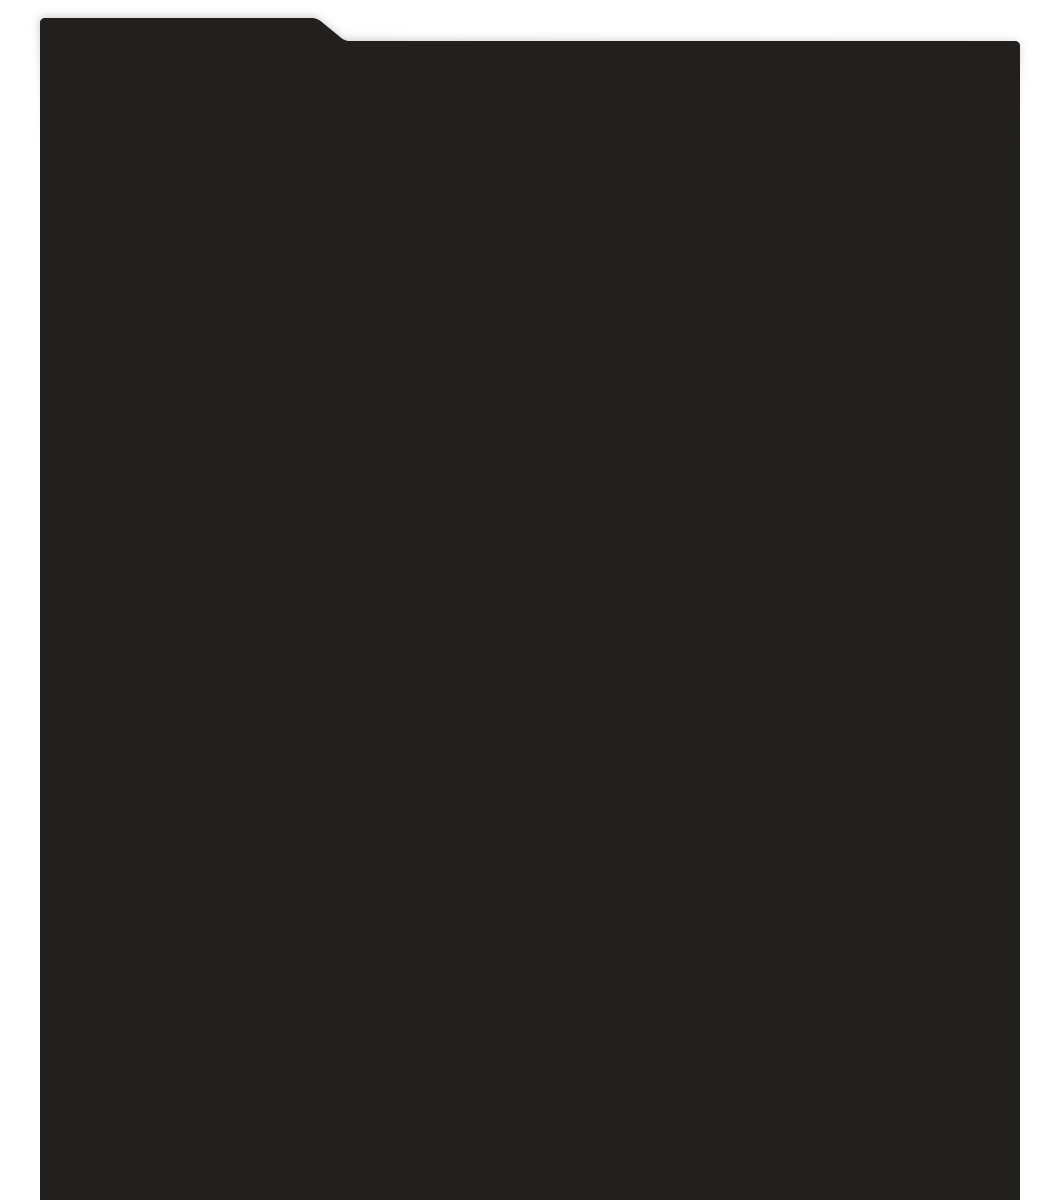
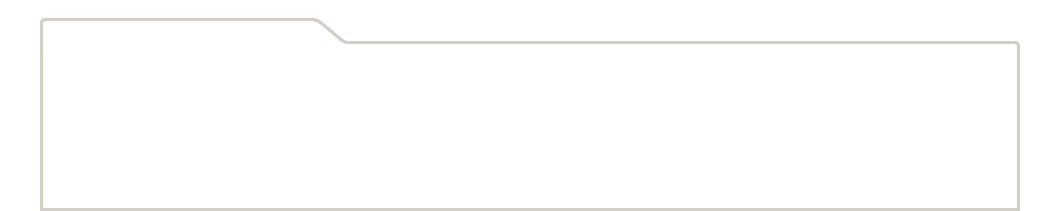
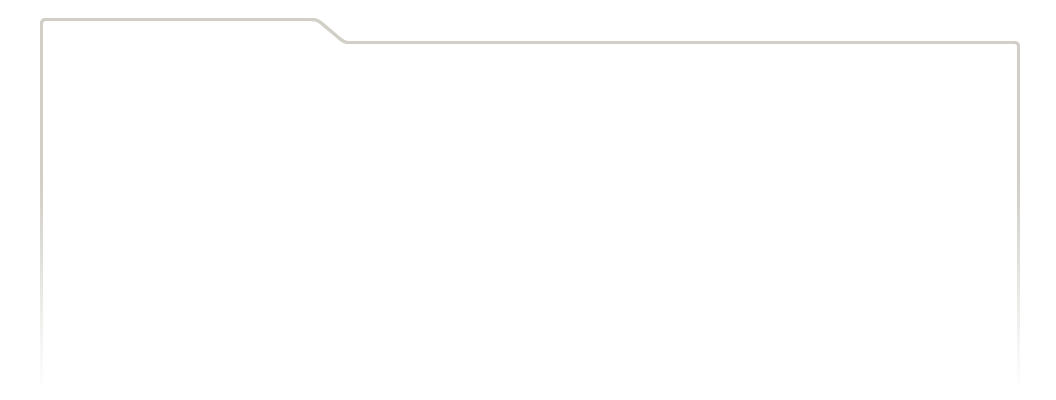
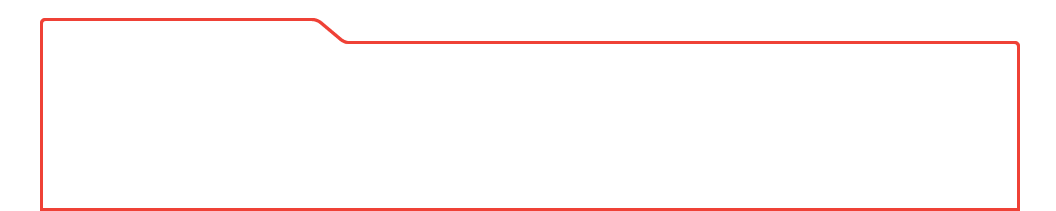
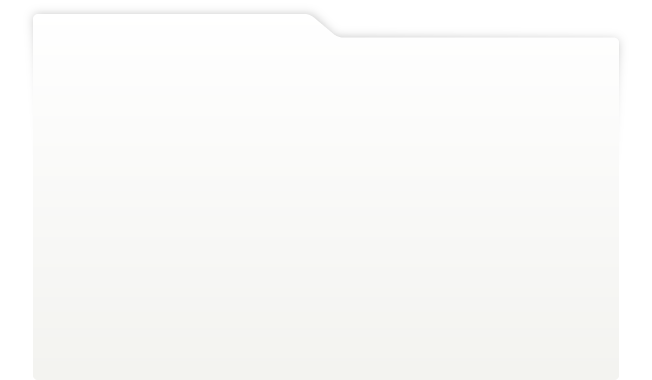
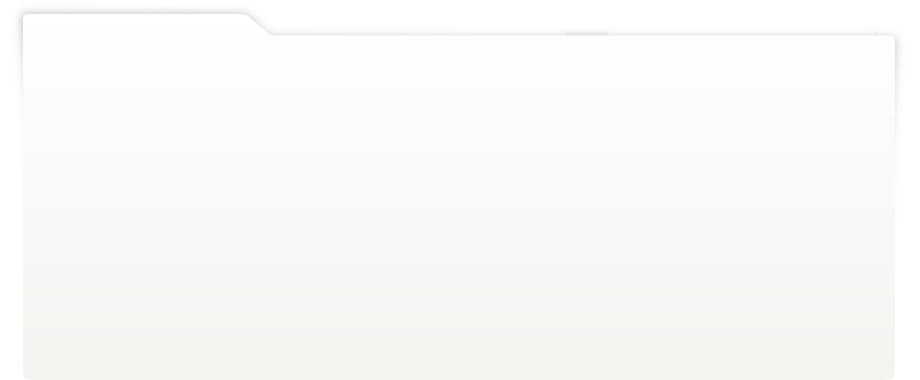
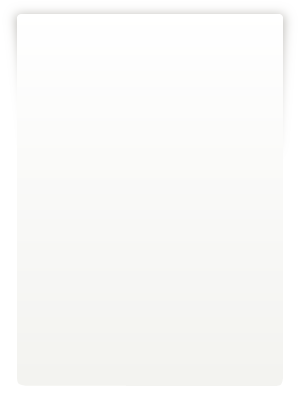
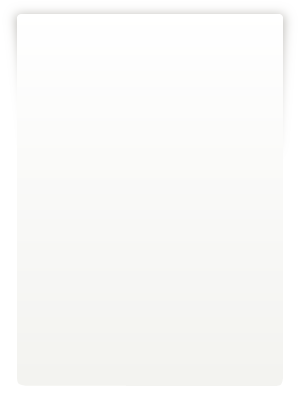
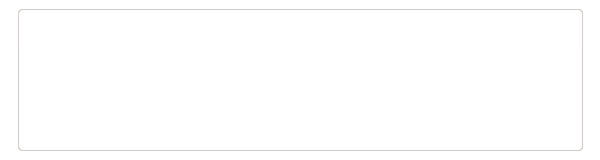
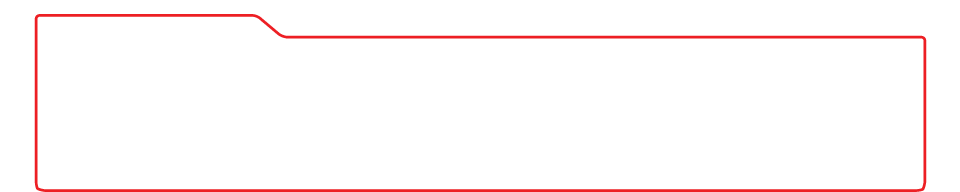
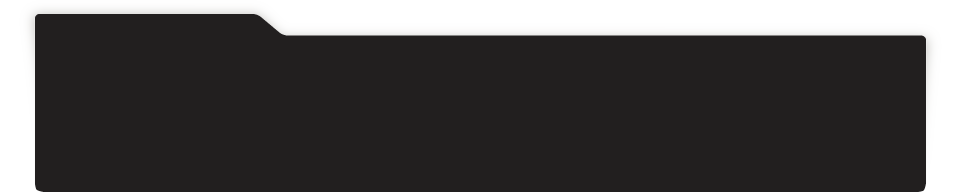
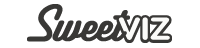
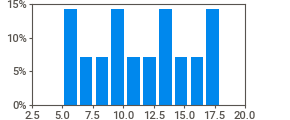
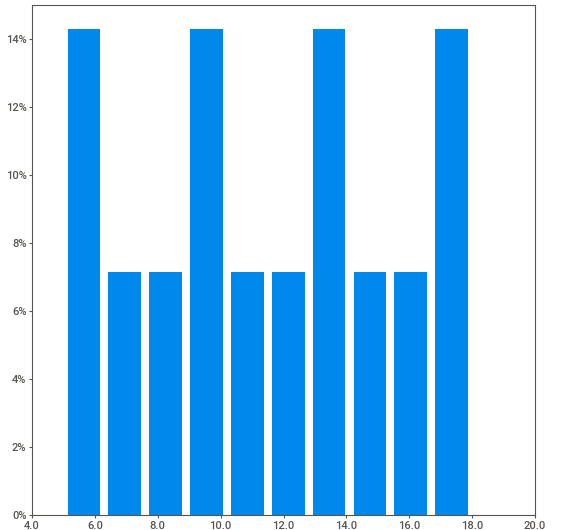
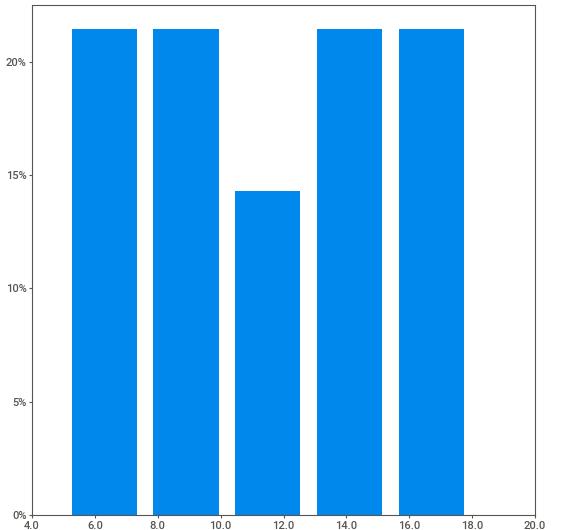
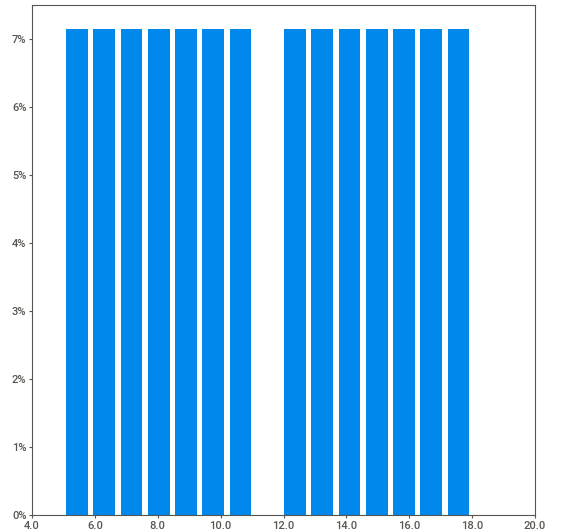
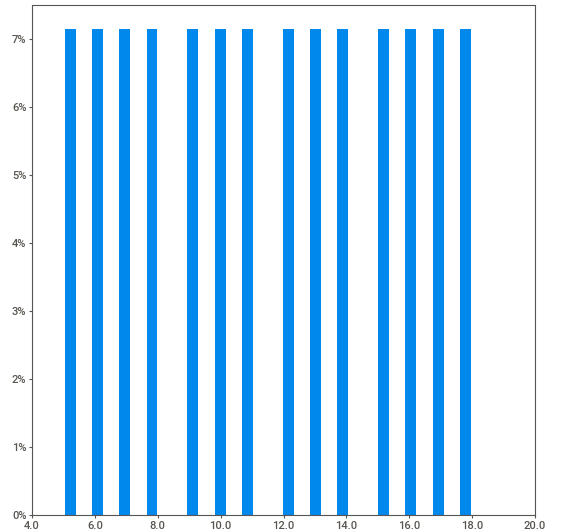
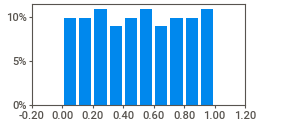
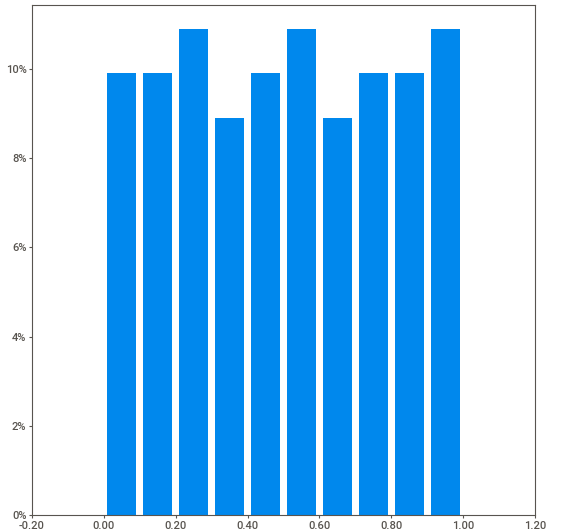
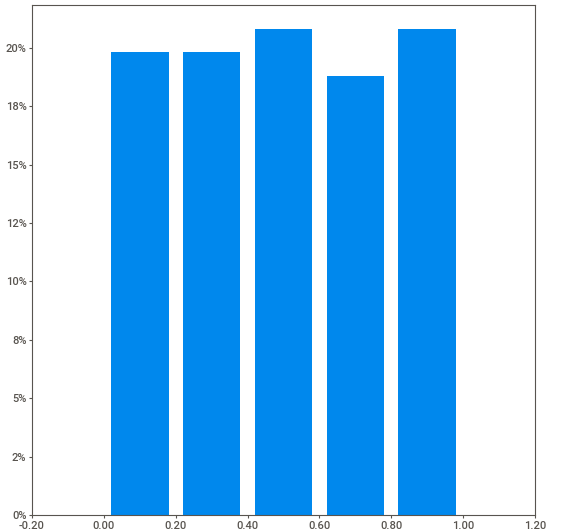
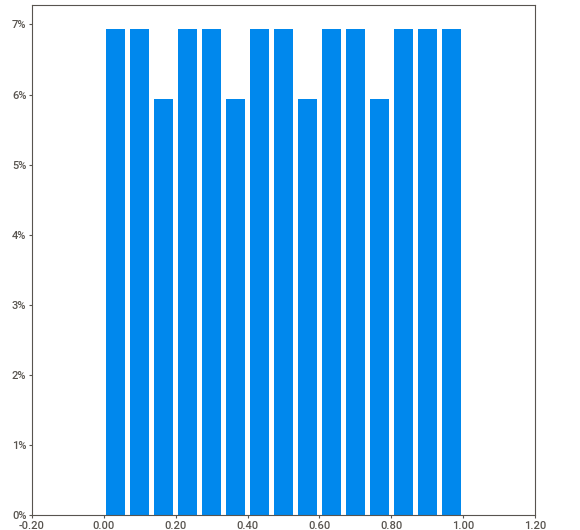
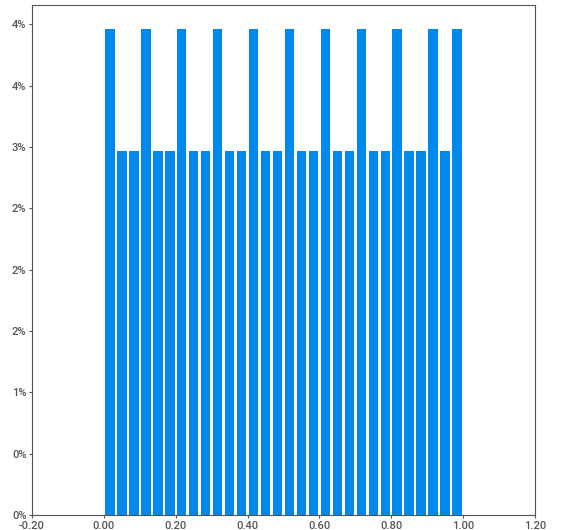
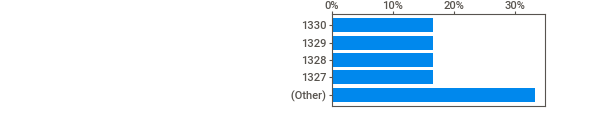
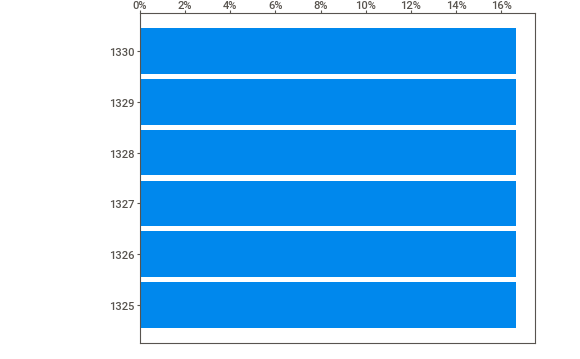
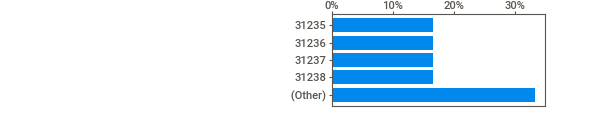
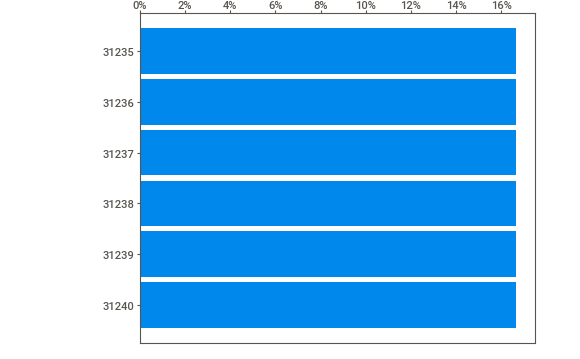
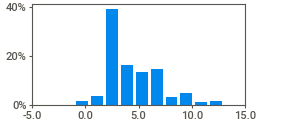
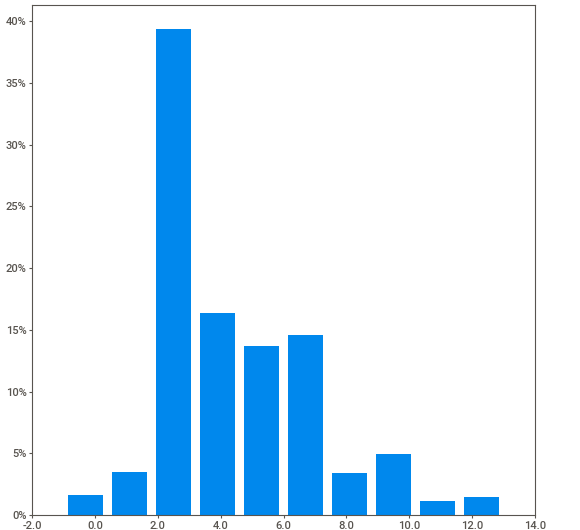
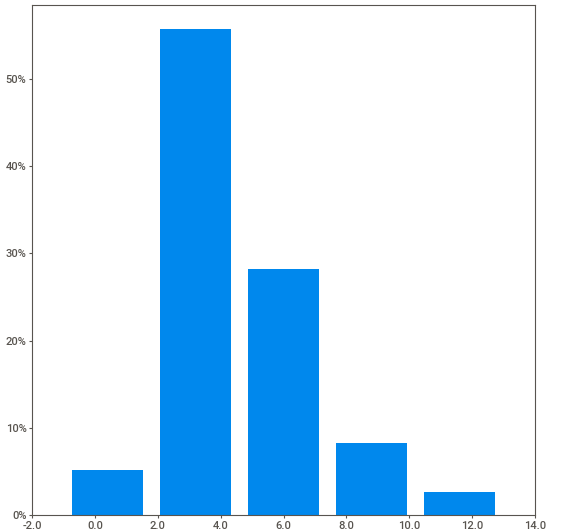
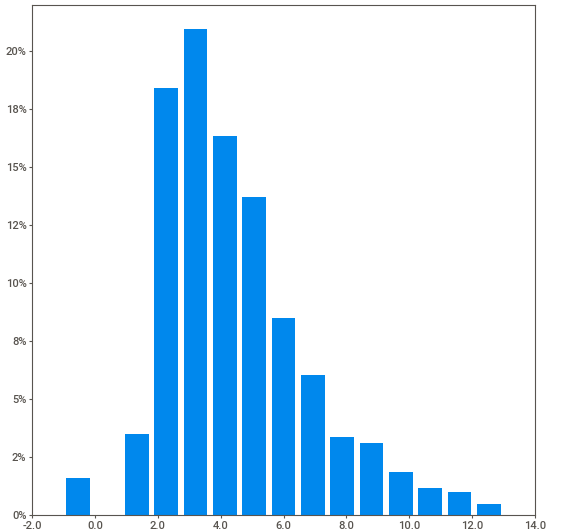
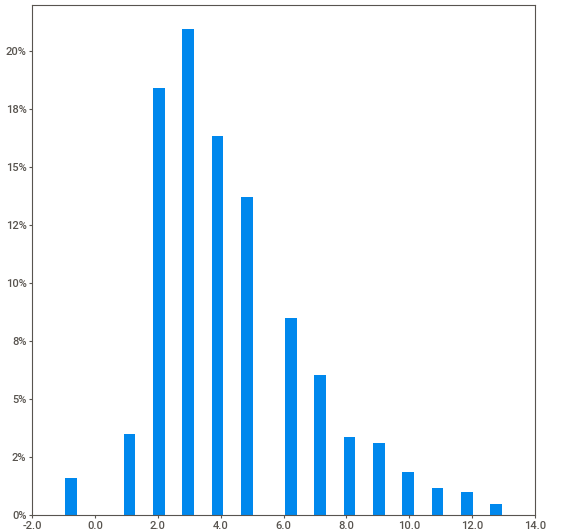
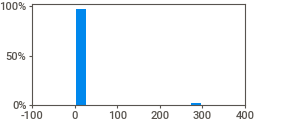
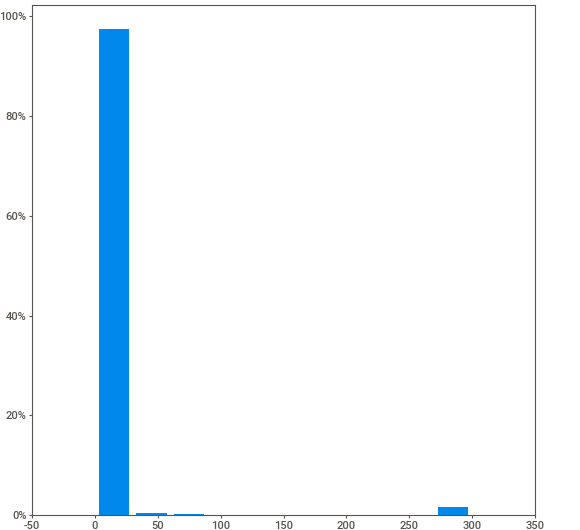
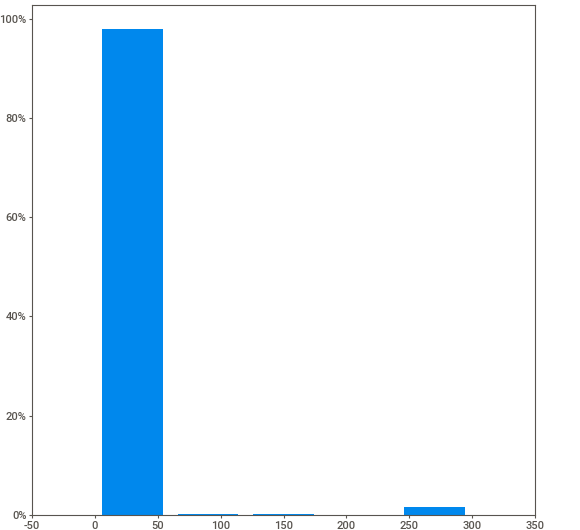
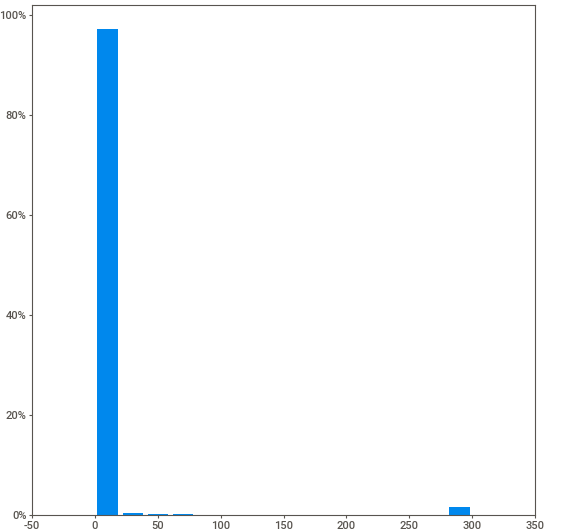
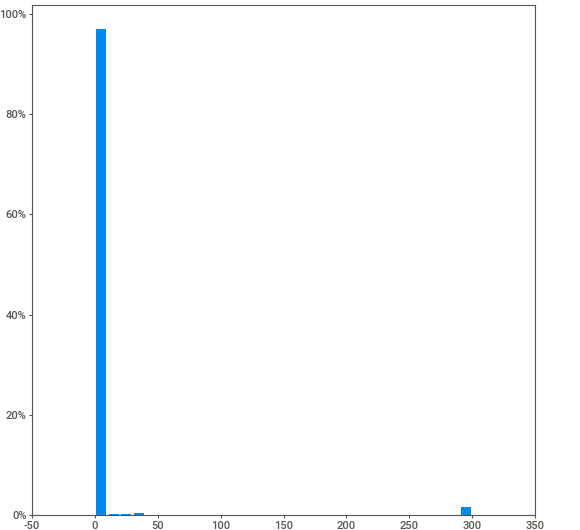
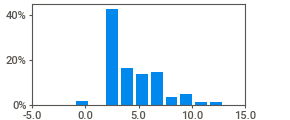
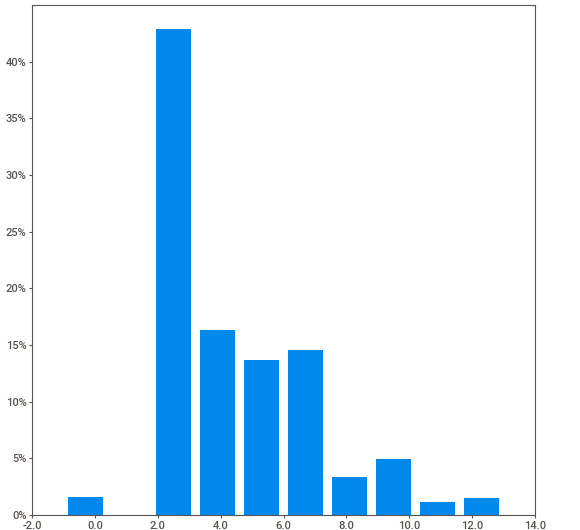
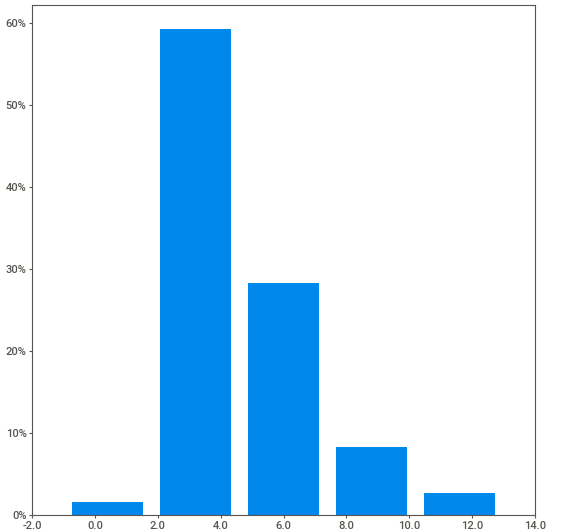
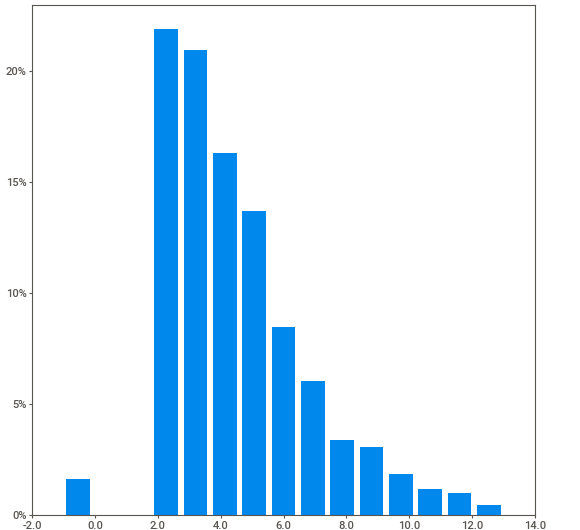
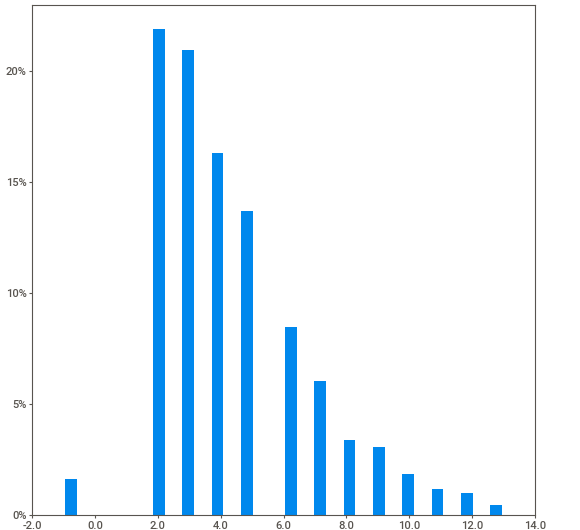
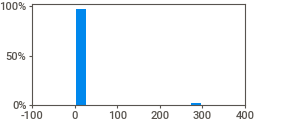
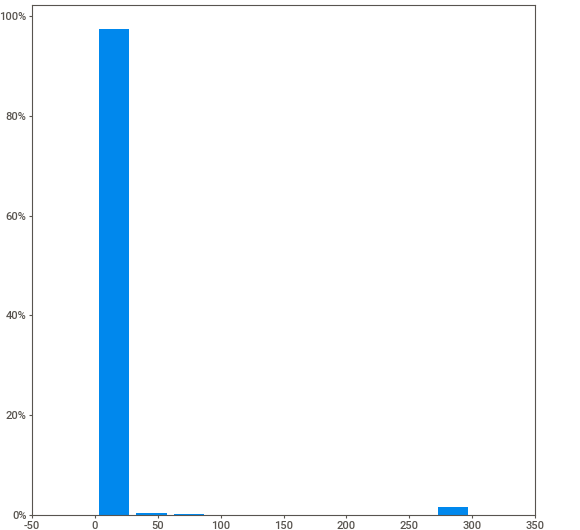
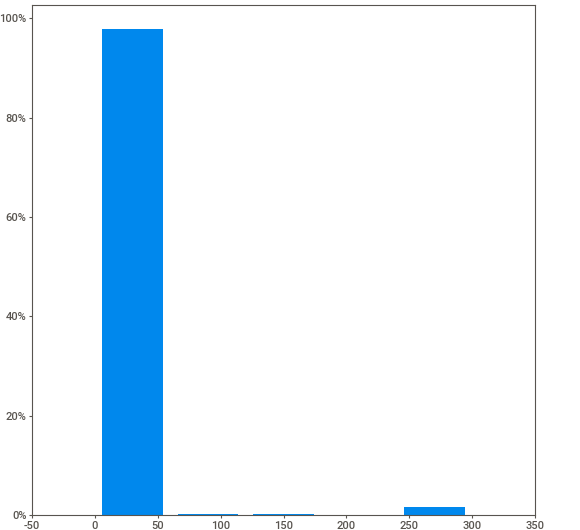
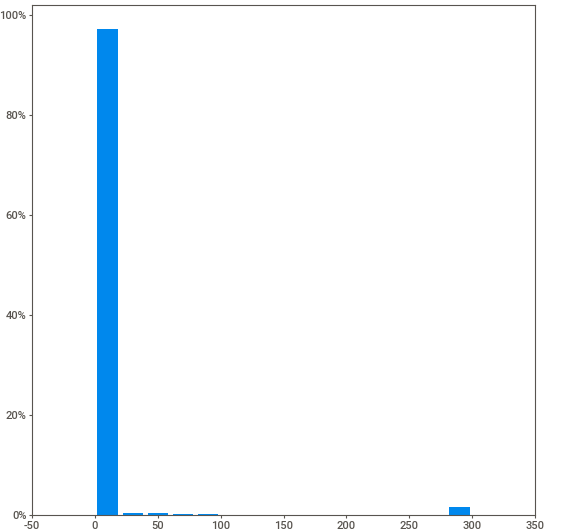
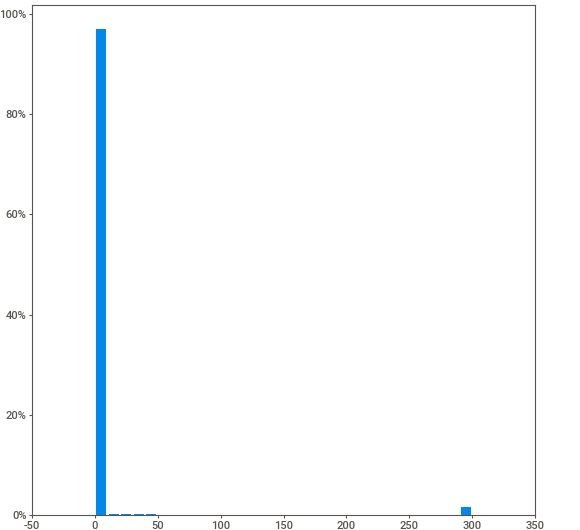
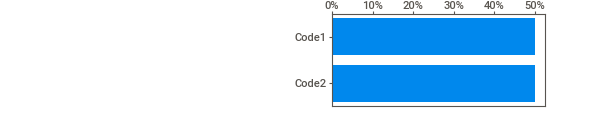
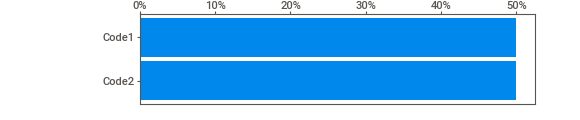
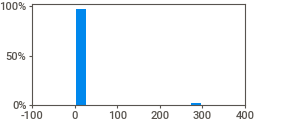
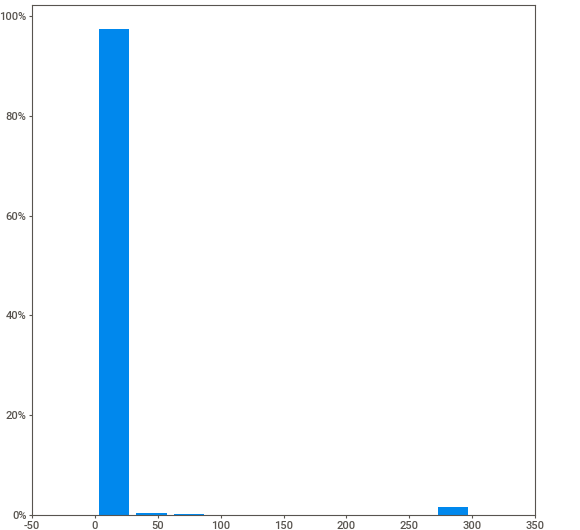
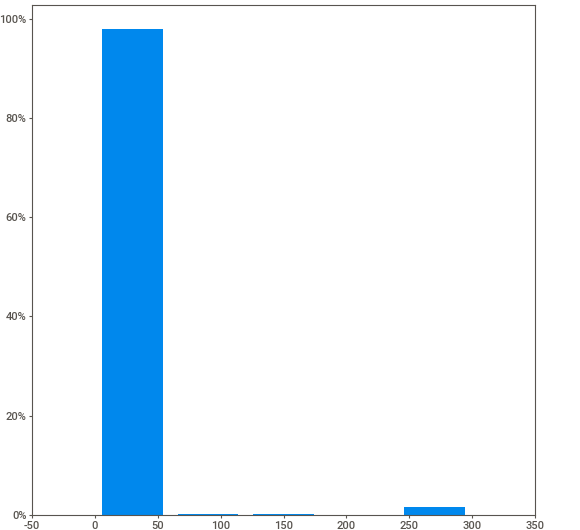
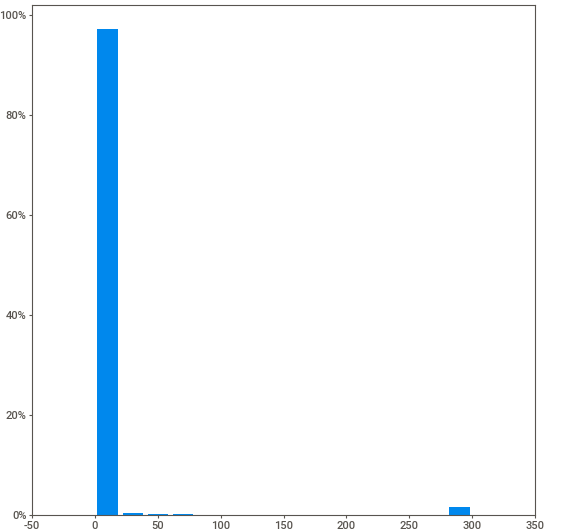
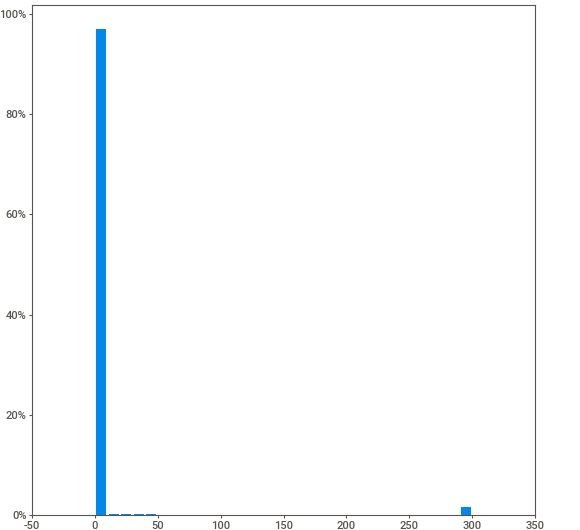
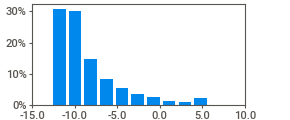
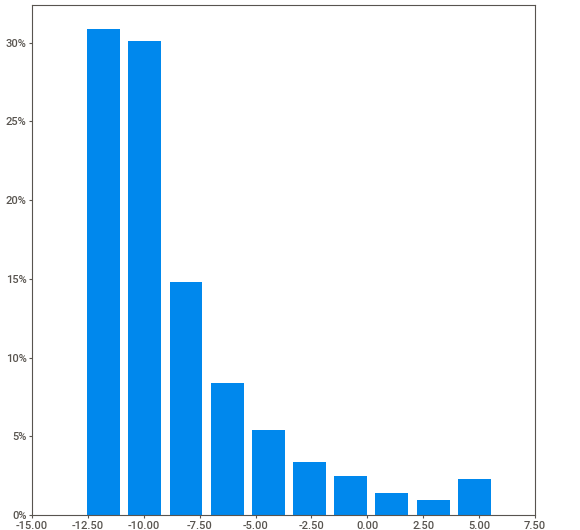
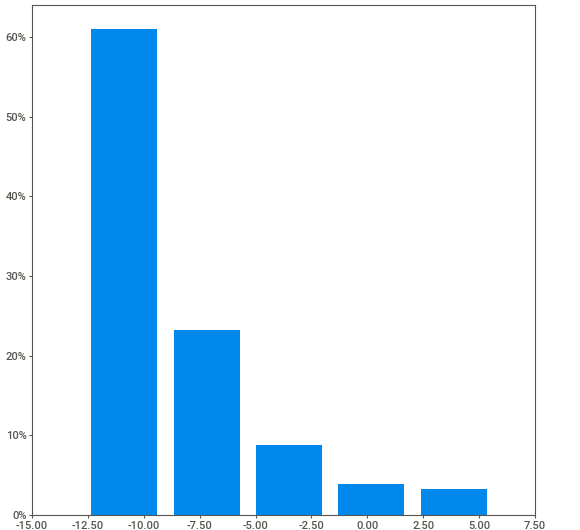
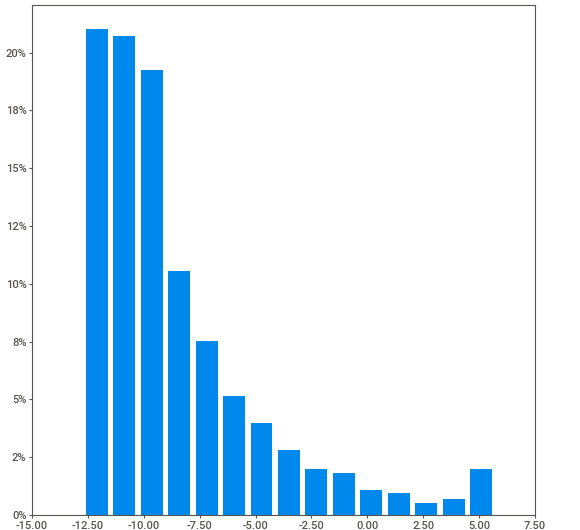
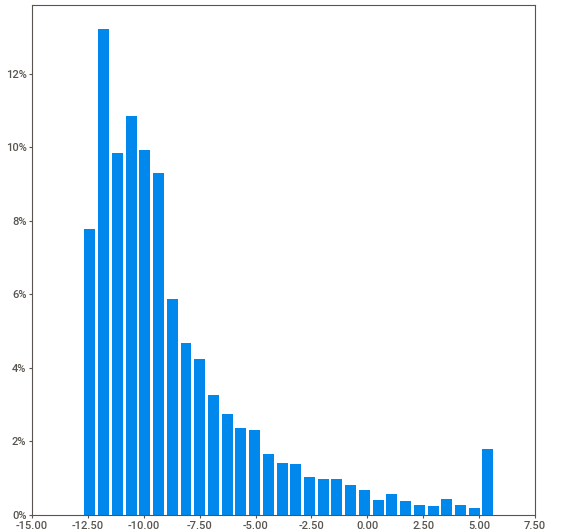
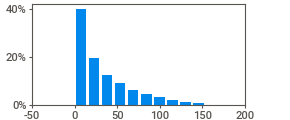
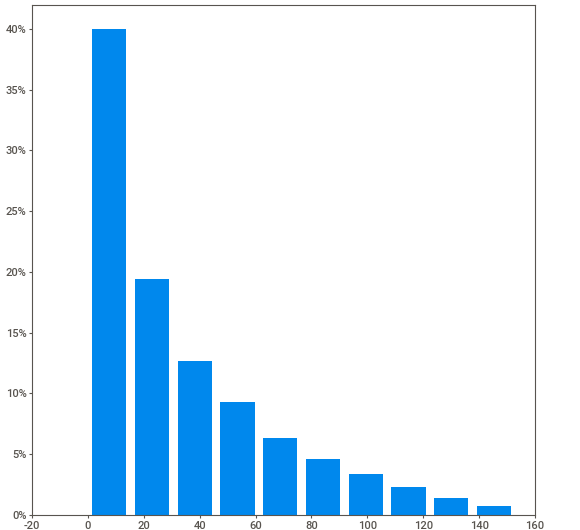
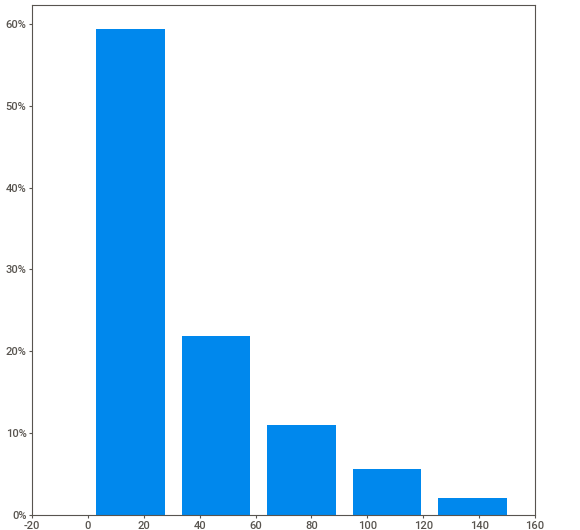
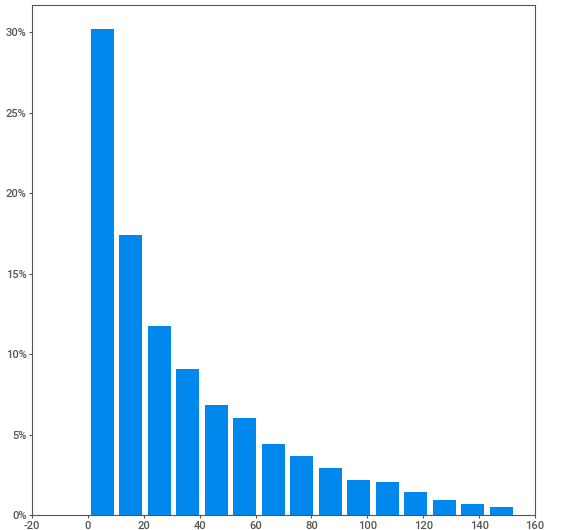
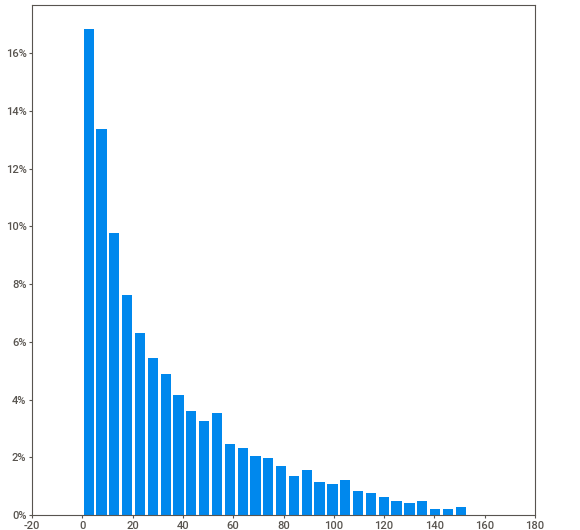
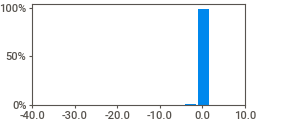
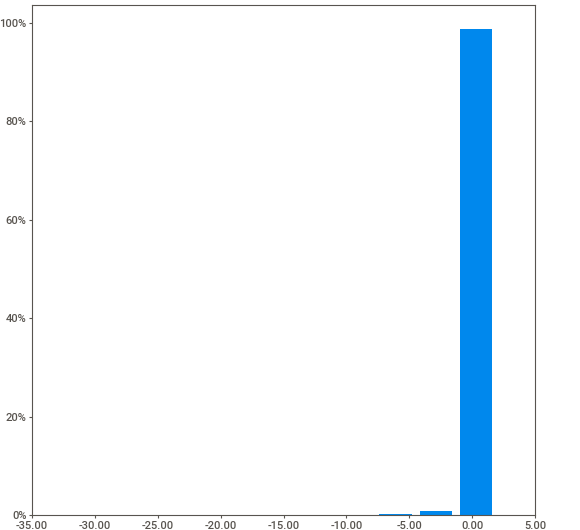
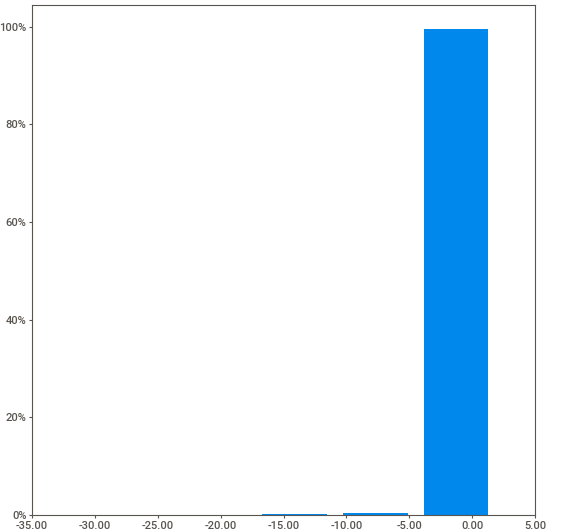
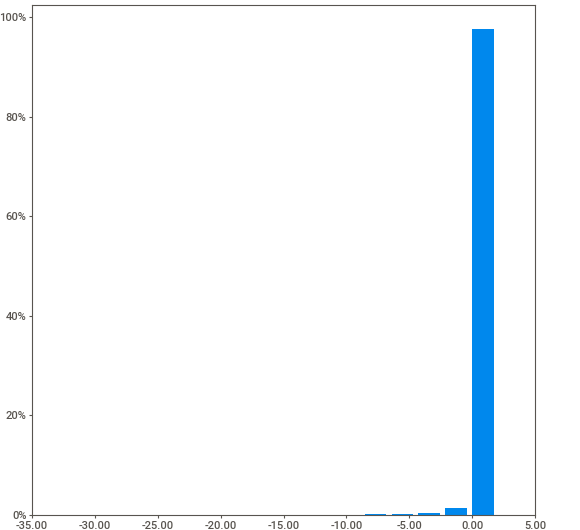
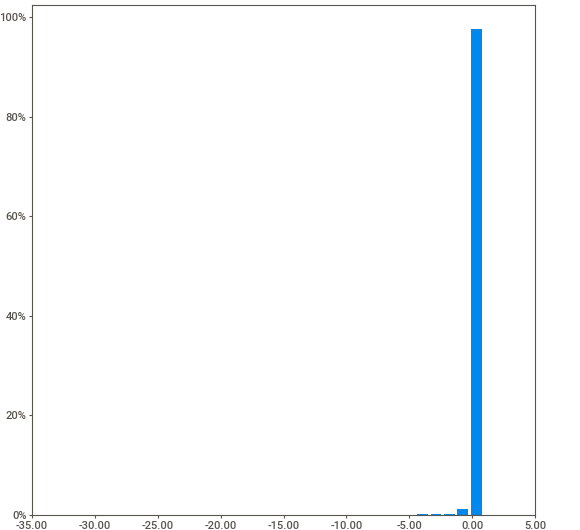
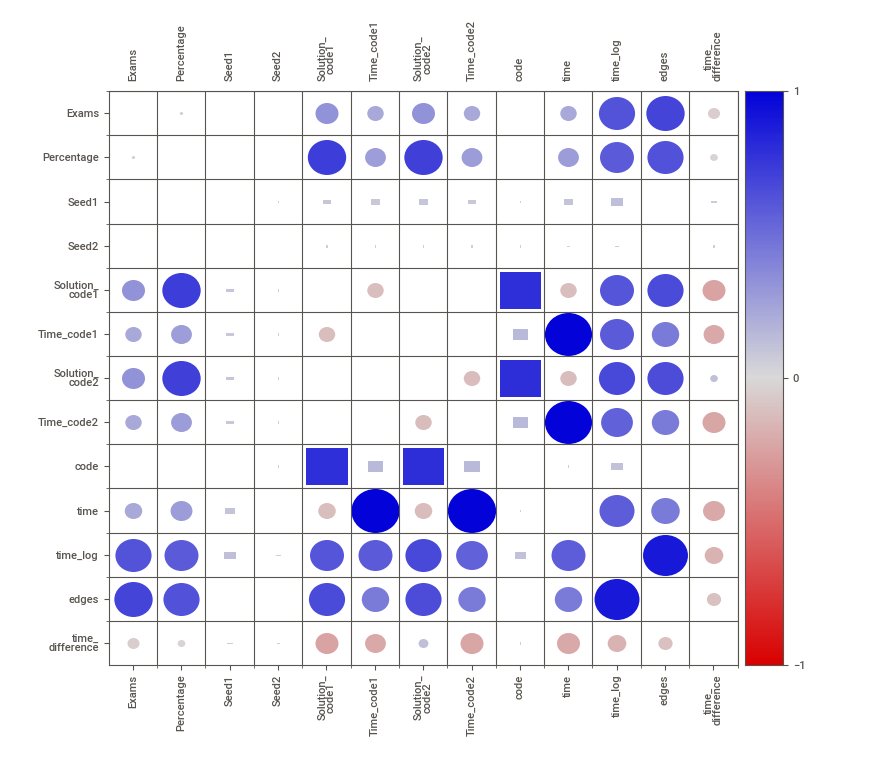
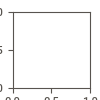

In [106]:
my_report.show_notebook(  w=None, 
                h=None, 
                scale=None,
                layout='widescreen',
                filepath=None)